In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report,make_scorer,accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix,precision_recall_curve

In [ ]:
training_df = pd.read_csv(r'path') # Actual training set
test_df = pd.read_csv(r'path')

validation_df = test_df.loc[test_df['repays_debt'] != '??'] # 2nd validation set 
testing_df = test_df.loc[test_df['repays_debt'] == '??']# Actual test set


----------------------------------------------------

-------------------------------------------------------------------

In [2]:
trial= pd.read_csv(r'path', index_col='period')

In [3]:
trial.head()

client_id  product8  product10  product13  product12  product11  \
period                                                                    
1               0         1          0          0          0          1   
2               0         1          1          1          1          0   
3               0         1          0          1          0          0   
4               0         1          1          1          0          1   
5               0         1          0          1          1          1   

        product4  product17  product2  product3  ...  \
period                                           ...   
1              0          0         1         1  ...   
2              0          0         1         1  ...   
3              1          0         0         1  ...   
4              1          1         0         1  ...   
5              0          0         0         1  ...   

        wire_transfers1_num_outbound  counter_num_inbound  \
period                                                      
1                                 12                   45   
2                                 14                   31   
3                                 13                   16   
4                                 16                   24   
5                                 10                   24   

        counter_num_outbound  securities_operations  securities_bought  \
period                                                                   
1                         61                      0                  0   
2                         50                      0                  0   
3                         47                      0                  0   
4                         53                      0                  0   
5                         53                      0                  0   

        securities_sold  counter_amt_tot  counter_num_tot  category  \
period                                                                
1                     0    192148.965822              106         2   
2                     0    -56342.014232               81         2   
3                     0   -159247.483476               63         2   
4                     0     12234.918920               77         2   
5                     0   -104456.783924               77         2   

        repays_debt  
period               
1                 0  
2                 0  
3                 0  
4                 0  
5                 0  

[5 rows x 43 columns]

In [4]:
trial.columns

Index(['client_id', 'product8', 'product10', 'product13', 'product12',
       'product11', 'product4', 'product17', 'product2', 'product3',
       'product1', 'product7', 'product6', 'product5', 'product14',
       'product15', 'product16', 'product9', 'has_products', 'balance',
       'left_bank', 'joined_bank', 'wire_transfers2_amt_inbound',
       'wire_transfers1_amt_inbound', 'wire_transfers2_amt_outbound',
       'wire_transfers1_amt_outbound', 'counter_amt_inbound',
       'counter_amt_outbound', 'securities_bought_amt', 'securities_sold_amt',
       'wire_transfers2_num_inbound', 'wire_transfers1_num_inbound',
       'wire_transfers2_num_outbound', 'wire_transfers1_num_outbound',
       'counter_num_inbound', 'counter_num_outbound', 'securities_operations',
       'securities_bought', 'securities_sold', 'counter_amt_tot',
       'counter_num_tot', 'category', 'repays_debt'],
      dtype='object')

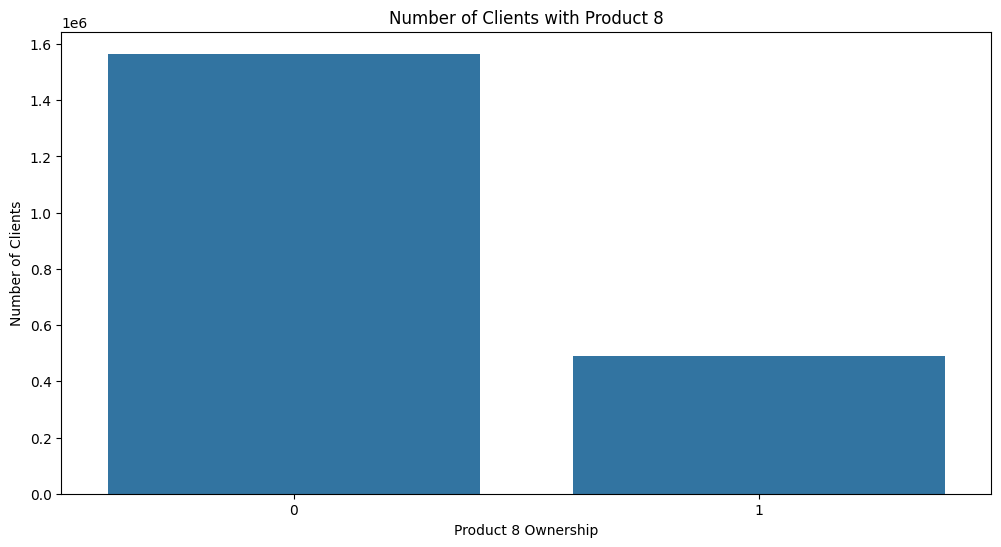

In [8]:
plt.figure(figsize=(12, 6))
sns.countplot(x='product8', data=trial)
plt.title('Number of Clients with Product 8')
plt.xlabel('Product 8 Ownership')
plt.ylabel('Number of Clients')
plt.show()

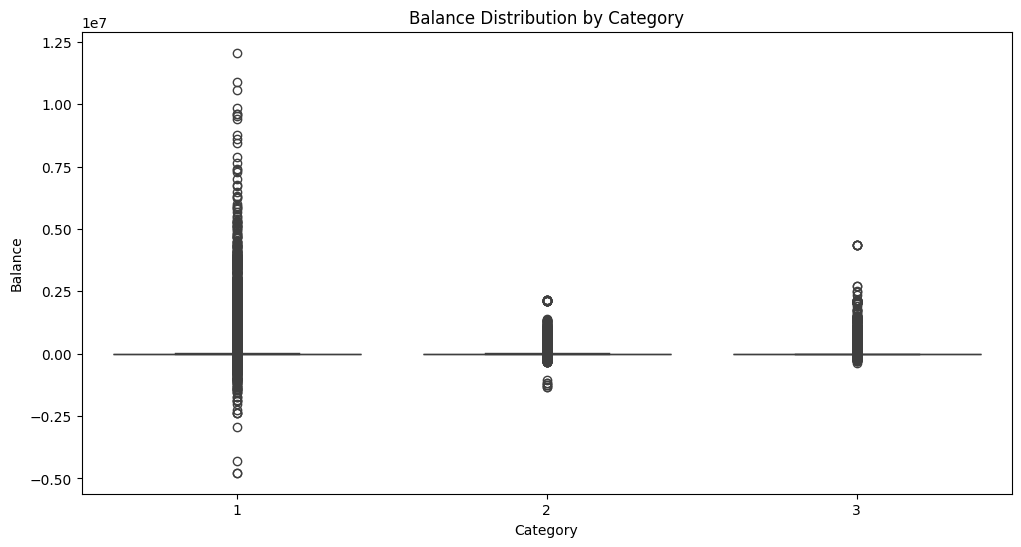

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='balance', data=trial)
plt.title('Balance Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Balance')
plt.show()

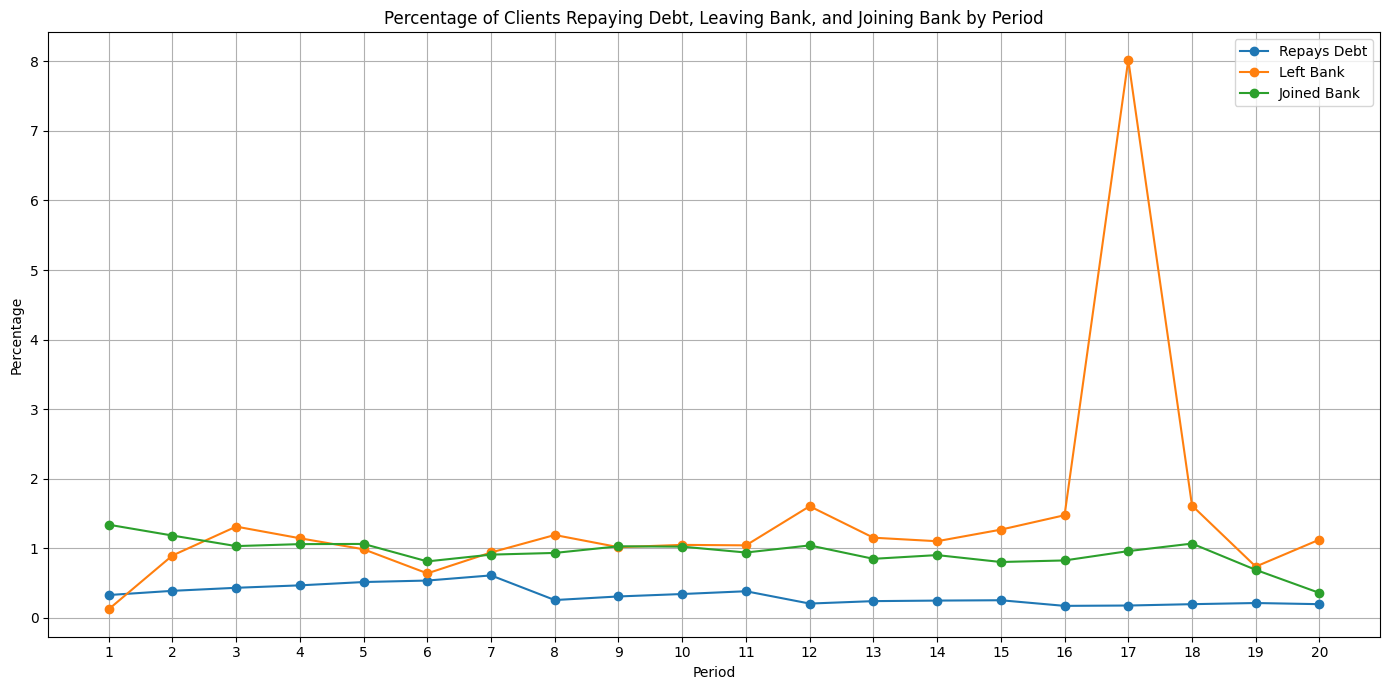

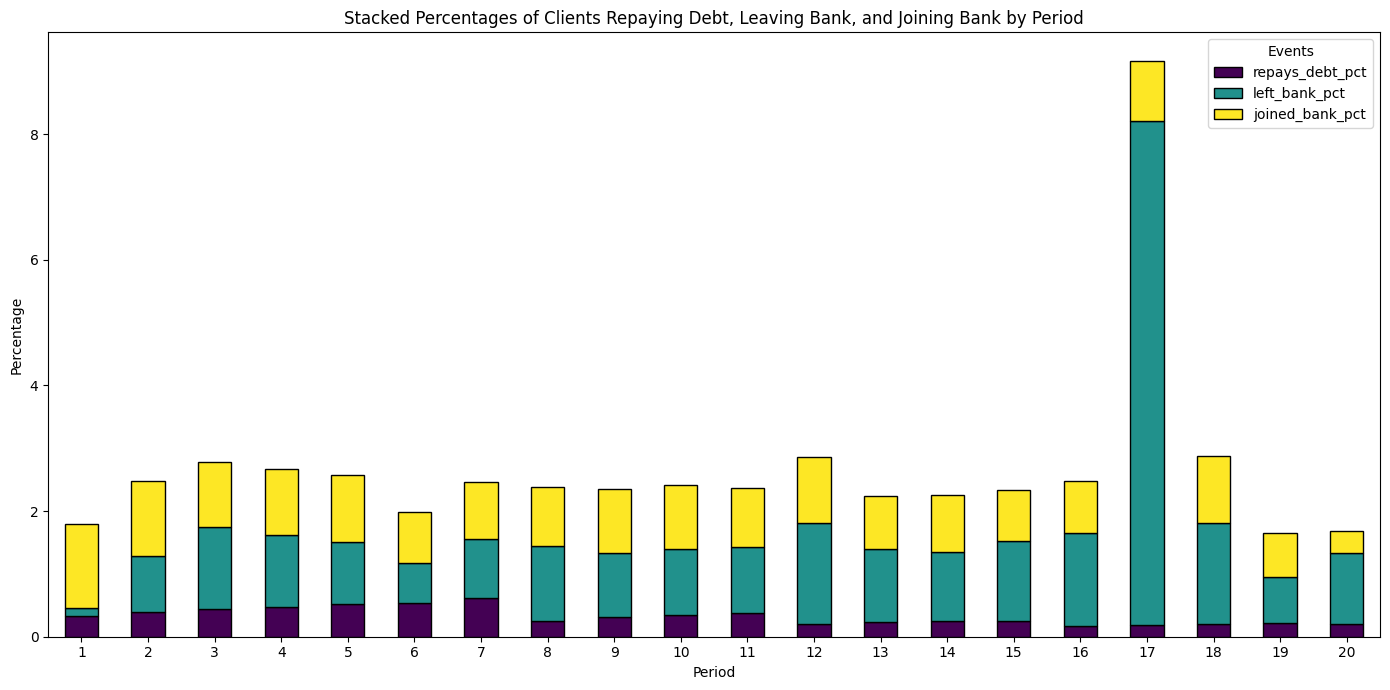

In [25]:
# Aggregate percentages by period
agg_df = trial.groupby('period').agg({
    'repays_debt': ['mean', 'size'],
    'left_bank': 'mean',
    'joined_bank': 'mean'
}).reset_index()

# Flatten MultiIndex columns
agg_df.columns = ['period', 'repays_debt_mean', 'total_clients', 'left_bank_mean', 'joined_bank_mean']

# Percentage of clients who repay debt, left bank, and joined bank
agg_df['repays_debt_pct'] = agg_df['repays_debt_mean'] * 100
agg_df['left_bank_pct'] = agg_df['left_bank_mean'] * 100
agg_df['joined_bank_pct'] = agg_df['joined_bank_mean'] * 100


plt.figure(figsize=(14, 7))

# Plot each percentage as a separate line
plt.plot(agg_df['period'], agg_df['repays_debt_pct'], marker='o', label='Repays Debt')
plt.plot(agg_df['period'], agg_df['left_bank_pct'], marker='o', label='Left Bank')
plt.plot(agg_df['period'], agg_df['joined_bank_pct'], marker='o', label='Joined Bank')

# Add labels and title
plt.title('Percentage of Clients Repaying Debt, Leaving Bank, and Joining Bank by Period')
plt.xlabel('Period')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.xticks(agg_df['period'])
plt.tight_layout()

plt.show()



stacked_df = agg_df[['period', 'repays_debt_pct', 'left_bank_pct', 'joined_bank_pct']].set_index('period')

# Plot
stacked_df.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis', edgecolor='black')

# Add labels and title
plt.title('Stacked Percentages of Clients Repaying Debt, Leaving Bank, and Joining Bank by Period')
plt.xlabel('Period')
plt.ylabel('Percentage')
plt.legend(title='Events')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

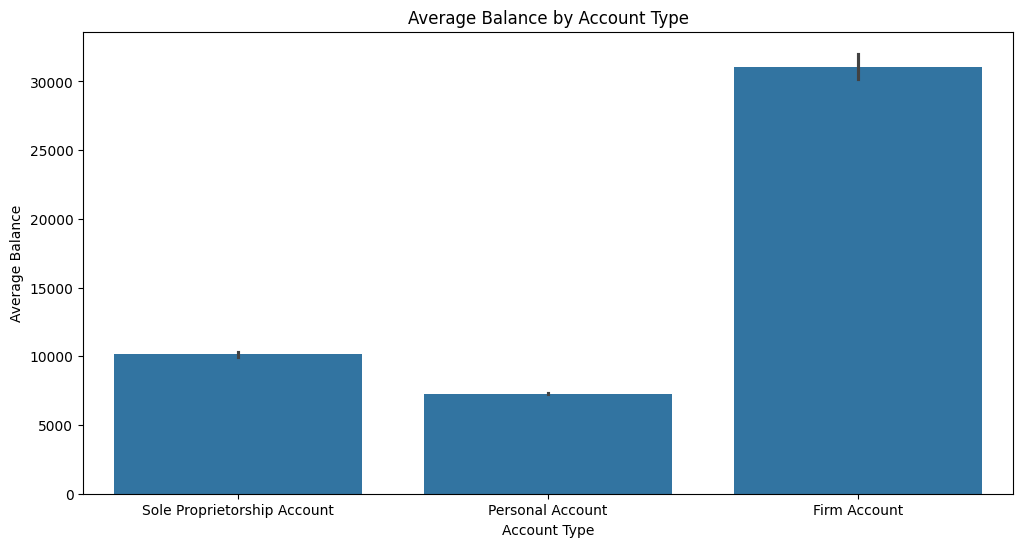

In [27]:
category_mapping = {
    1: 'Firm Account',
    2: 'Sole Proprietorship Account',
    3: 'Personal Account'
}

# Apply the mapping
trial['category_label'] = trial['category'].map(category_mapping)


plt.figure(figsize=(12, 6))

# Plot the bar plot with the new category labels
sns.barplot(x='category_label', y='balance', data=trial, estimator='mean')

# Add labels and title
plt.title('Average Balance by Account Type')
plt.xlabel('Account Type')
plt.ylabel('Average Balance')

# Show plot
plt.show()

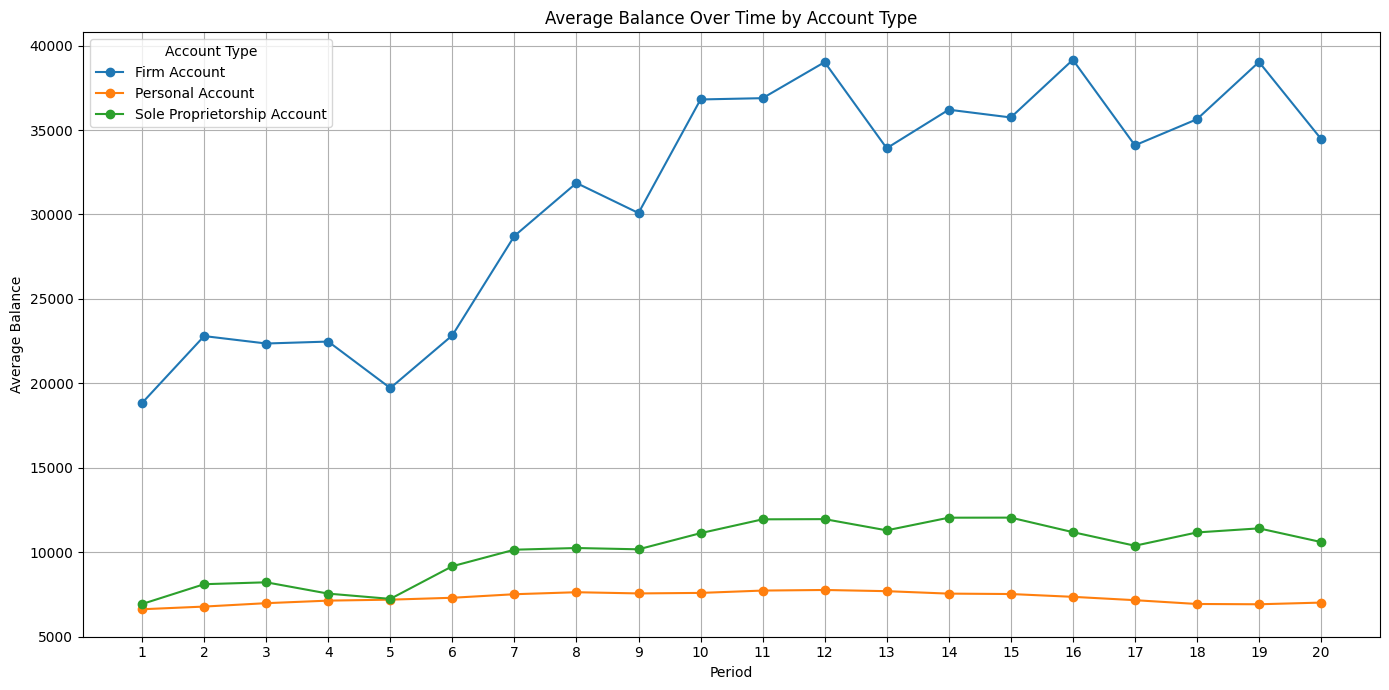

In [29]:
trial['category_label'] = trial['category'].map(category_mapping)

# Aggregate data
agg_df = trial.groupby(['period', 'category_label']).agg({'balance': 'mean'}).reset_index()

# Rename columns for clarity
agg_df.rename(columns={'balance': 'average_balance'}, inplace=True)




# Plot the data
plt.figure(figsize=(14, 7))

# Plot each account type separately
for label in agg_df['category_label'].unique():
    subset = agg_df[agg_df['category_label'] == label]
    plt.plot(subset['period'], subset['average_balance'], marker='o', label=label)

# Add labels and title
plt.title('Average Balance Over Time by Account Type')
plt.xlabel('Period')
plt.ylabel('Average Balance')
plt.legend(title='Account Type')
plt.grid(True)
plt.xticks(subset['period'].unique())  # Ensure all periods are shown
plt.tight_layout()

# Show plot
plt.show()

<Figure size 1200x600 with 0 Axes>

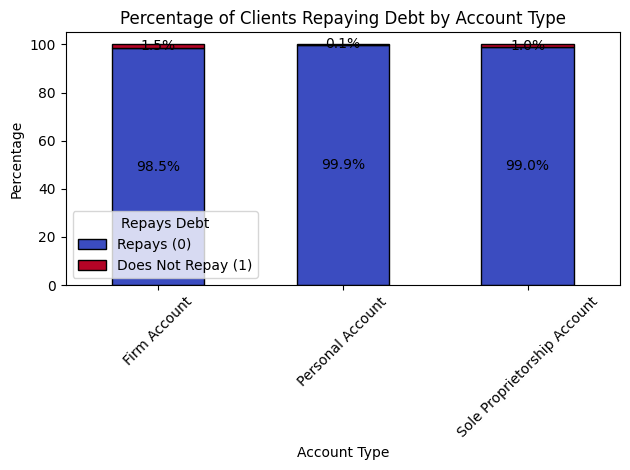

In [35]:
category_mapping = {
    1: 'Firm Account',
    2: 'Sole Proprietorship Account',
    3: 'Personal Account'
}

# Apply the mapping
trial['category_label'] = trial['category'].map(category_mapping)

# Calculate counts and percentages
count_df = trial.groupby('category_label')['repays_debt'].value_counts().unstack().fillna(0)
count_df.columns = ['repays_debt', 'does_not_repay']
percentage_df = count_df.div(count_df.sum(axis=1), axis=0) * 100
percentage_df = percentage_df.reset_index()


plt.figure(figsize=(12, 6))

# Plotting the stacked bar chart
ax = percentage_df.plot(kind='bar', x='category_label', stacked=True, colormap='coolwarm', edgecolor='black')

# Add labels and title
plt.title('Percentage of Clients Repaying Debt by Account Type')
plt.xlabel('Account Type')
plt.ylabel('Percentage')
plt.legend(title='Repays Debt', labels=['Repays (0)', 'Does Not Repay (1)'])
plt.xticks(rotation=45)

# Add annotations
for i, row in percentage_df.iterrows():
    bottom = 0
    for label, value in zip(row.index[1:], row.values[1:]):
        height = value
        # Add annotation
        ax.text(i, bottom + height / 2, f'{height:.1f}%', ha='center', va='center', color='black', fontsize=10)
        bottom += height

plt.tight_layout()
plt.show()

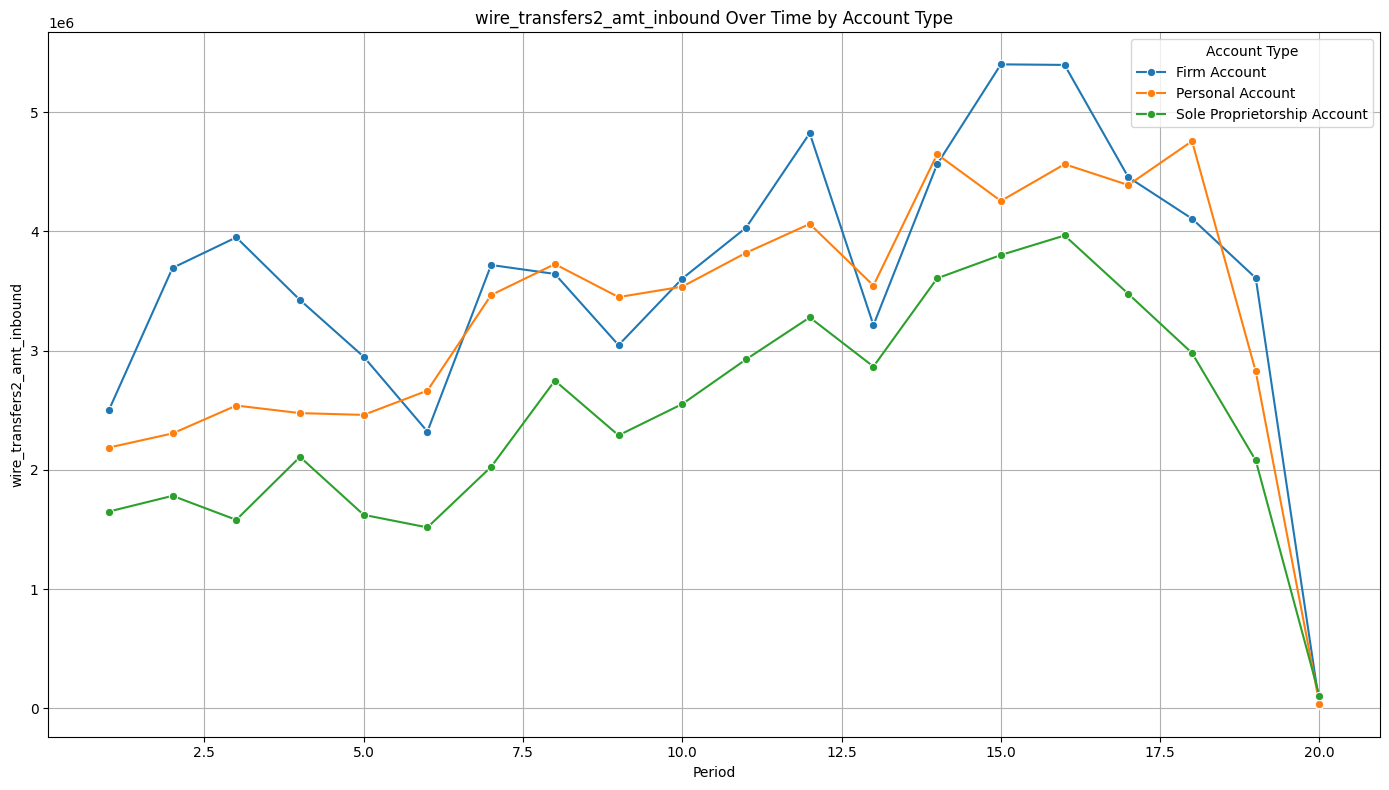

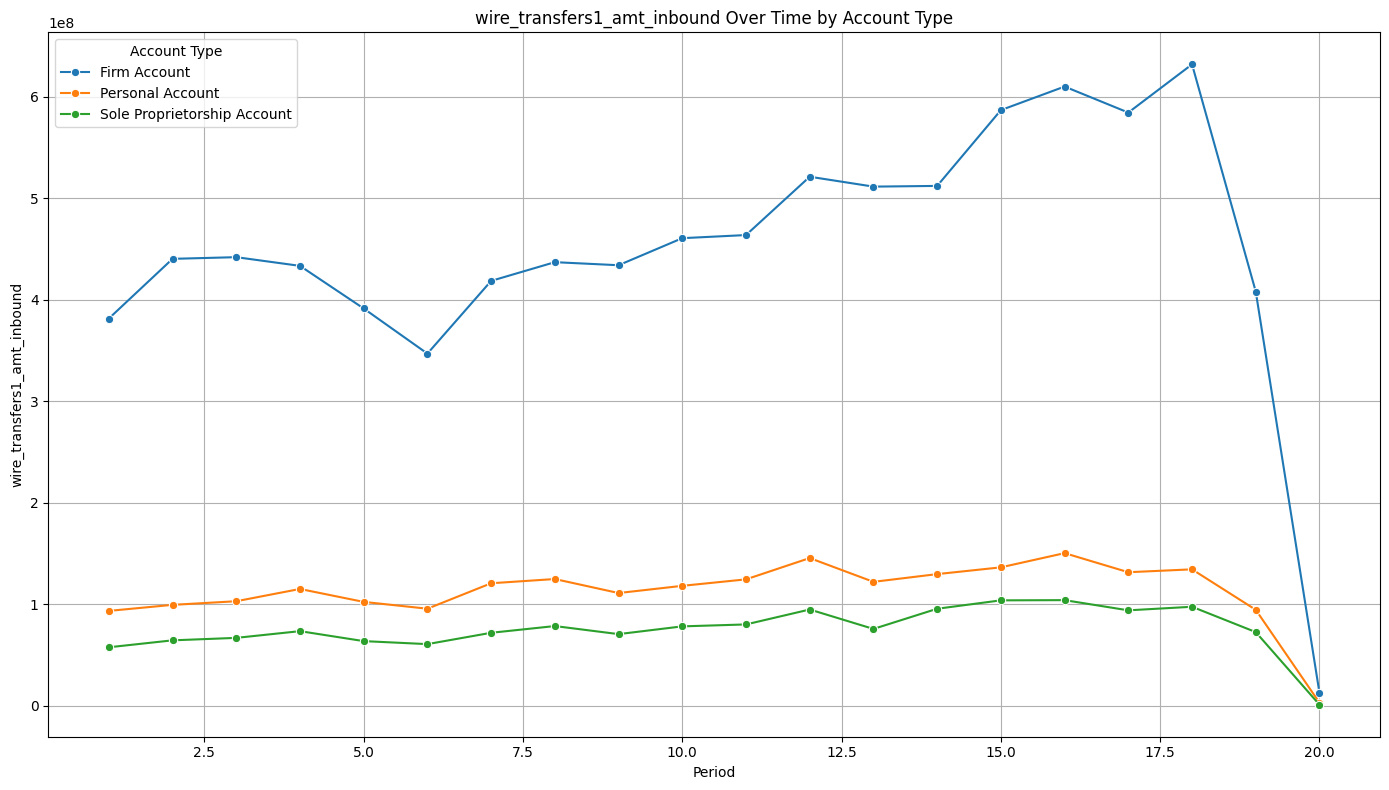

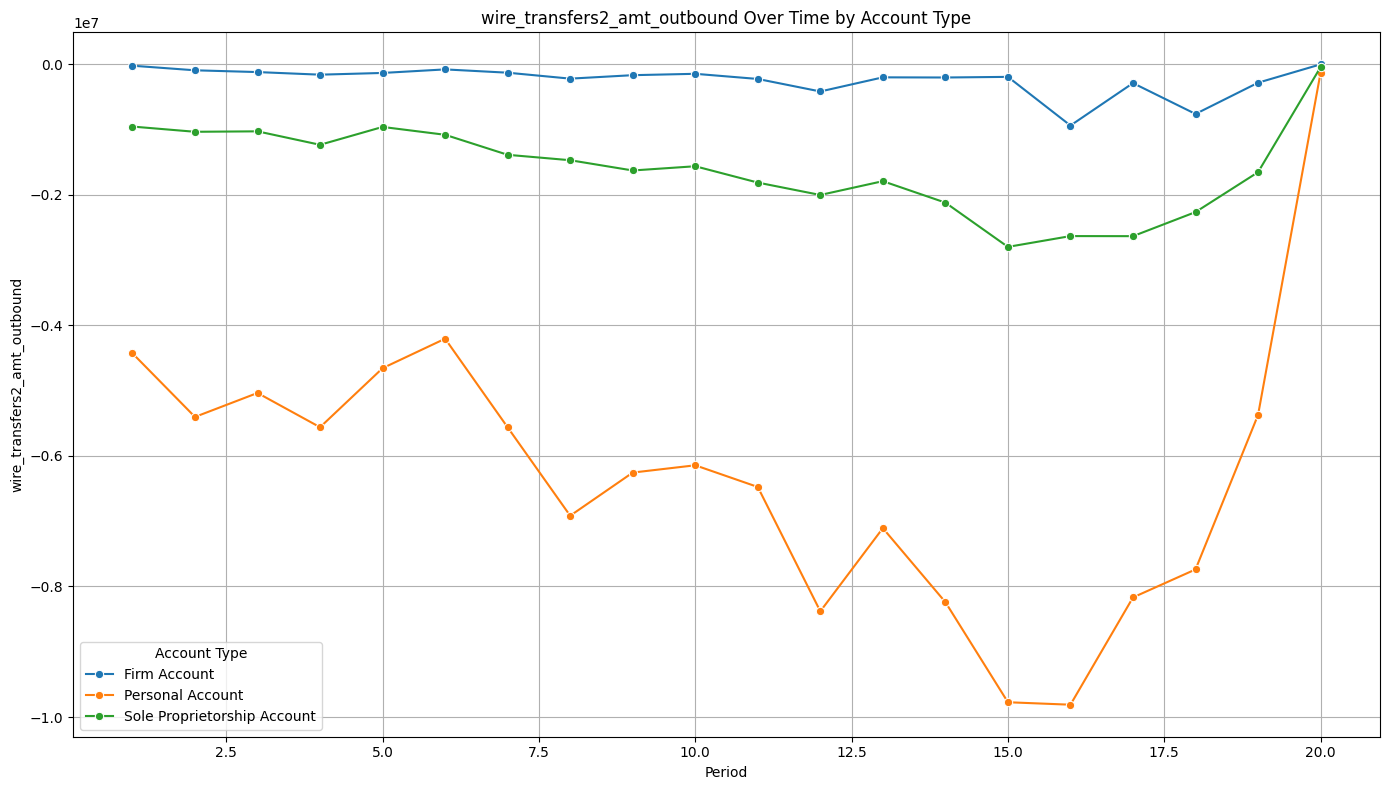

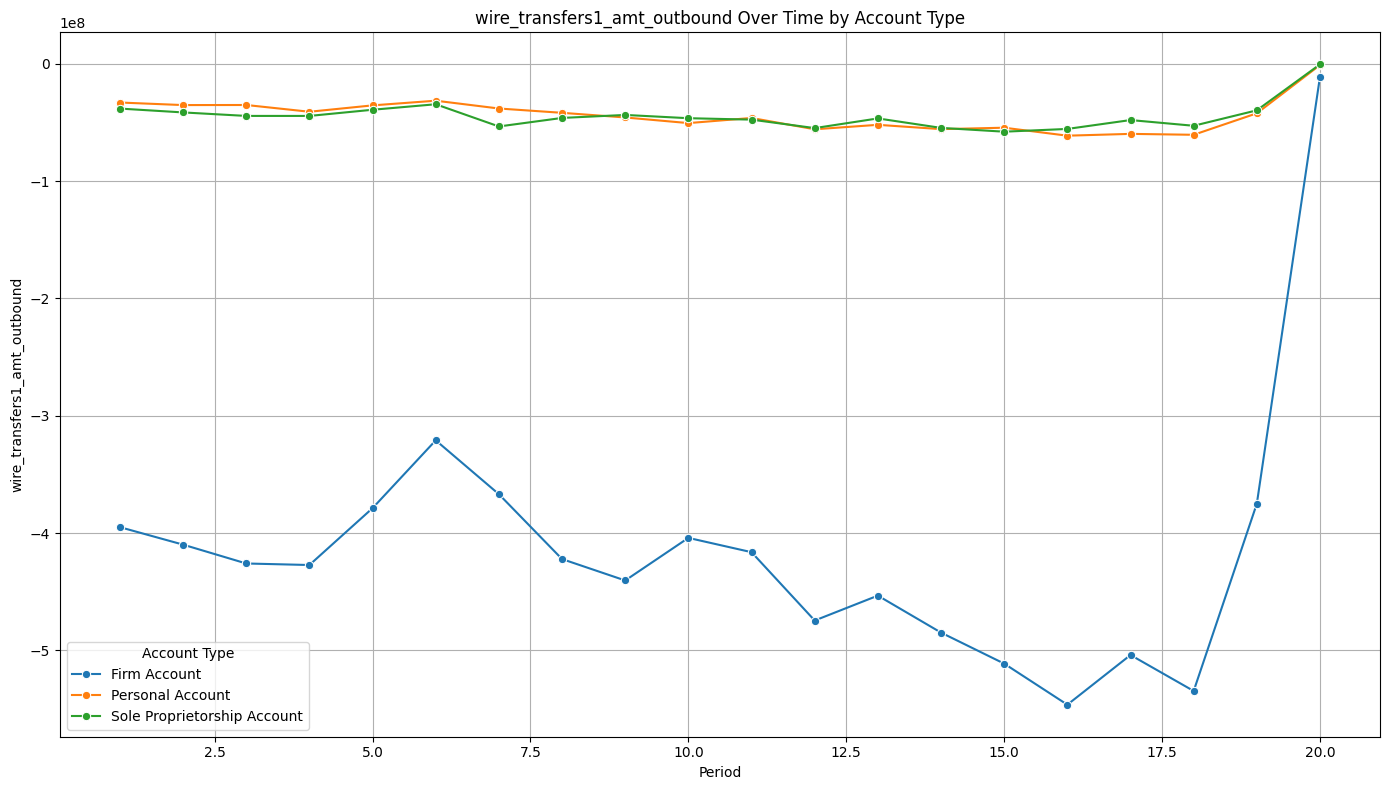

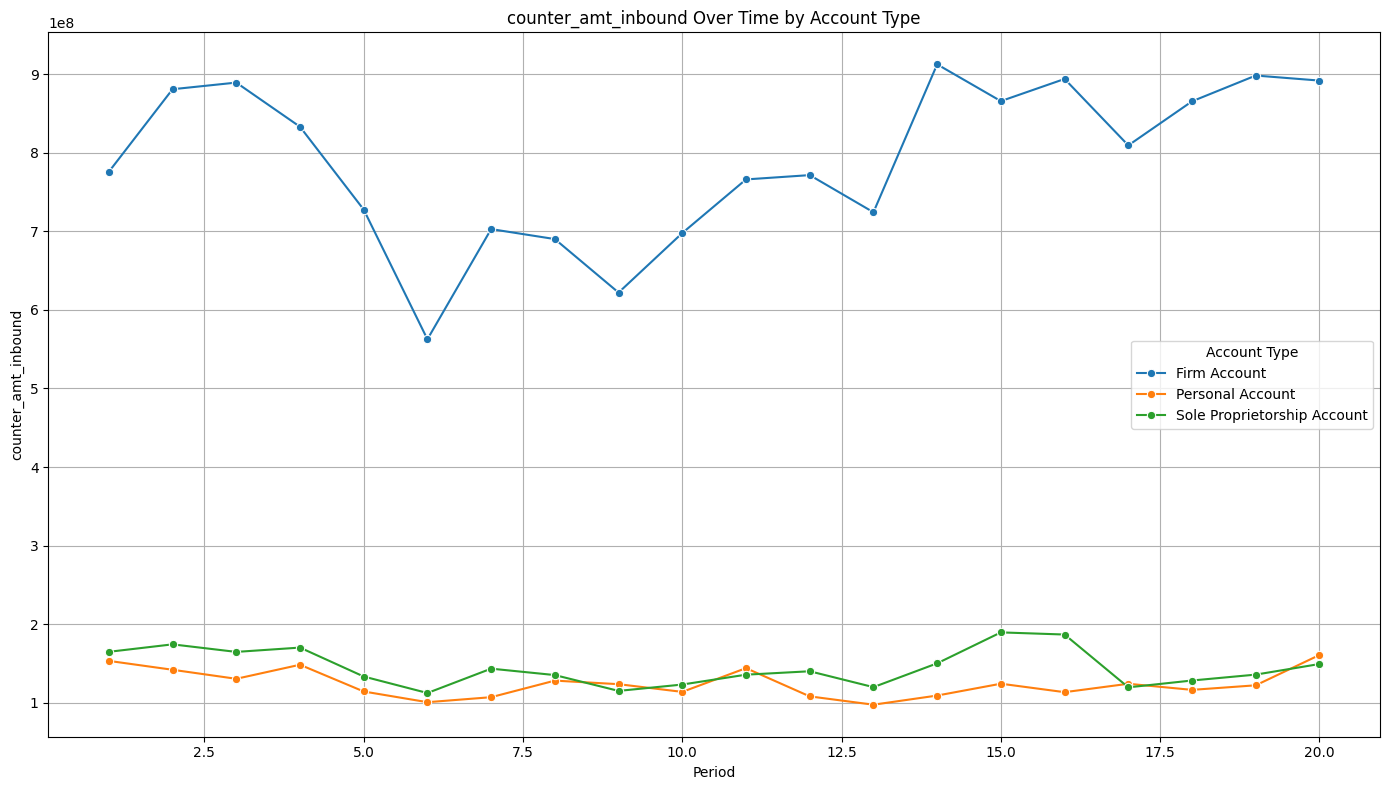

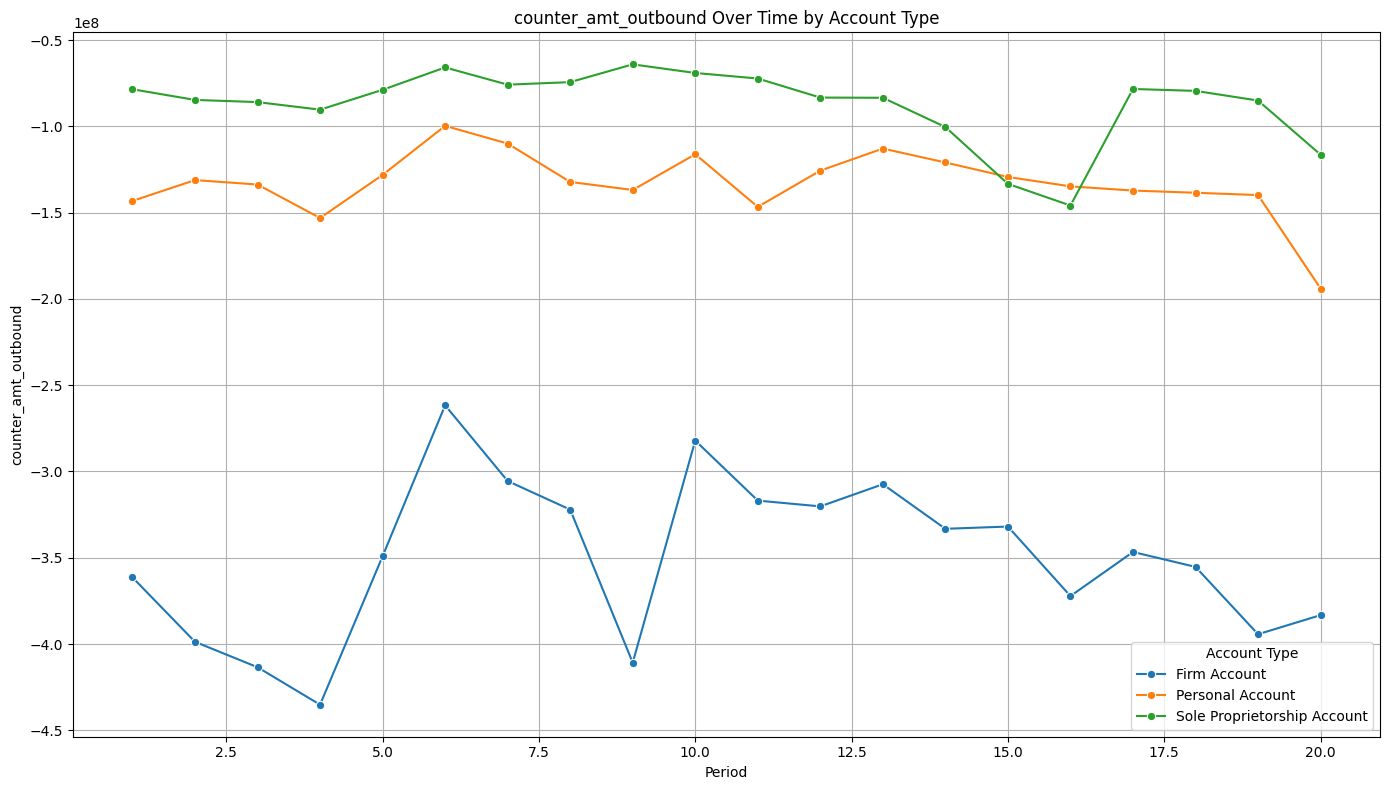

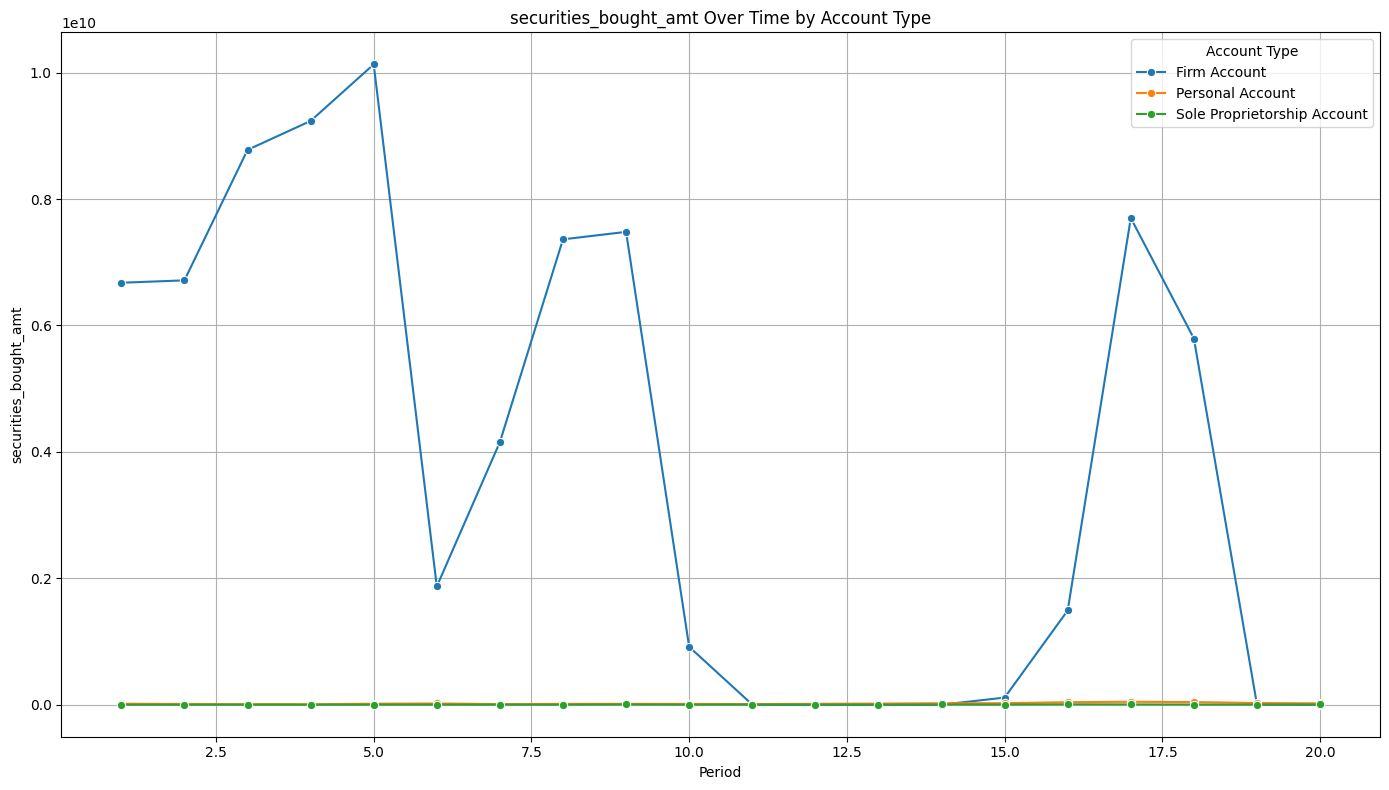

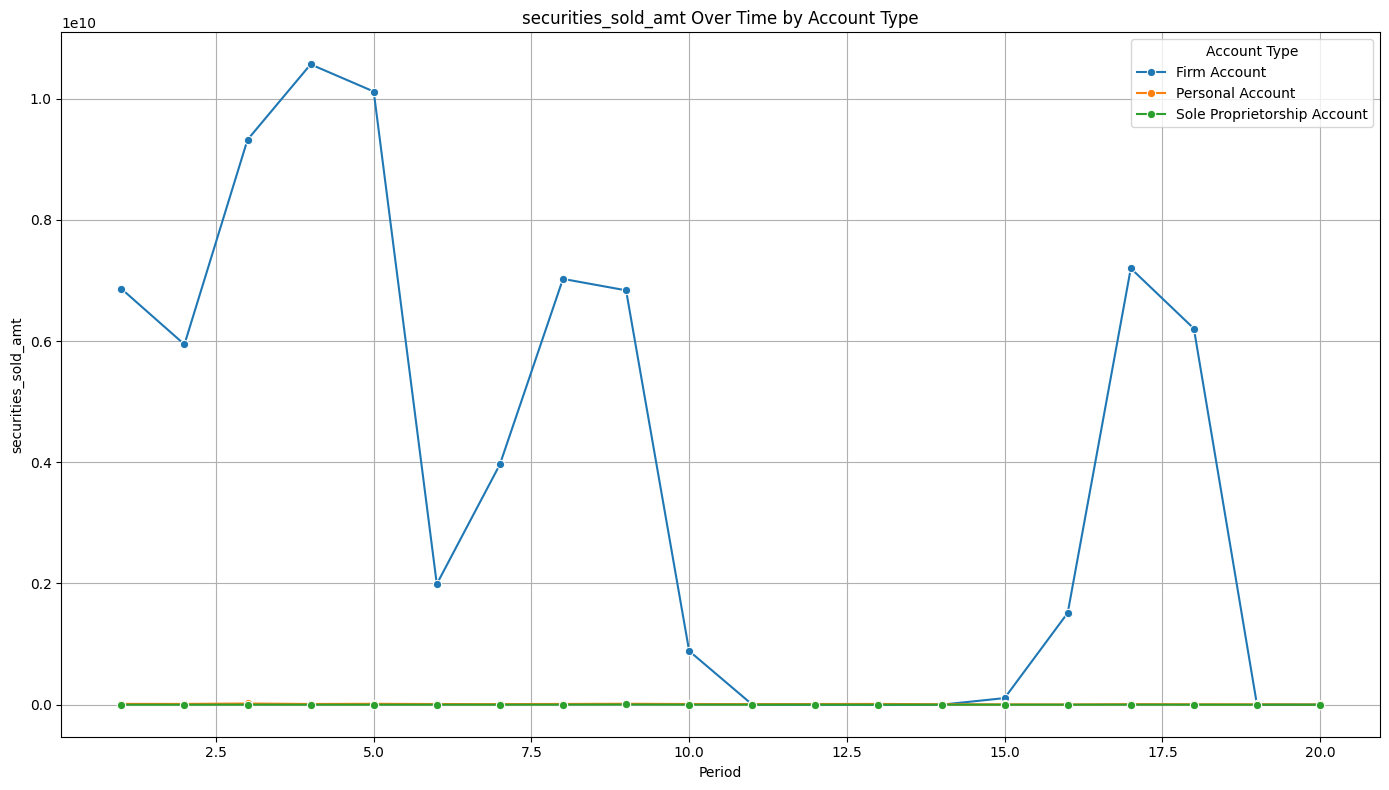

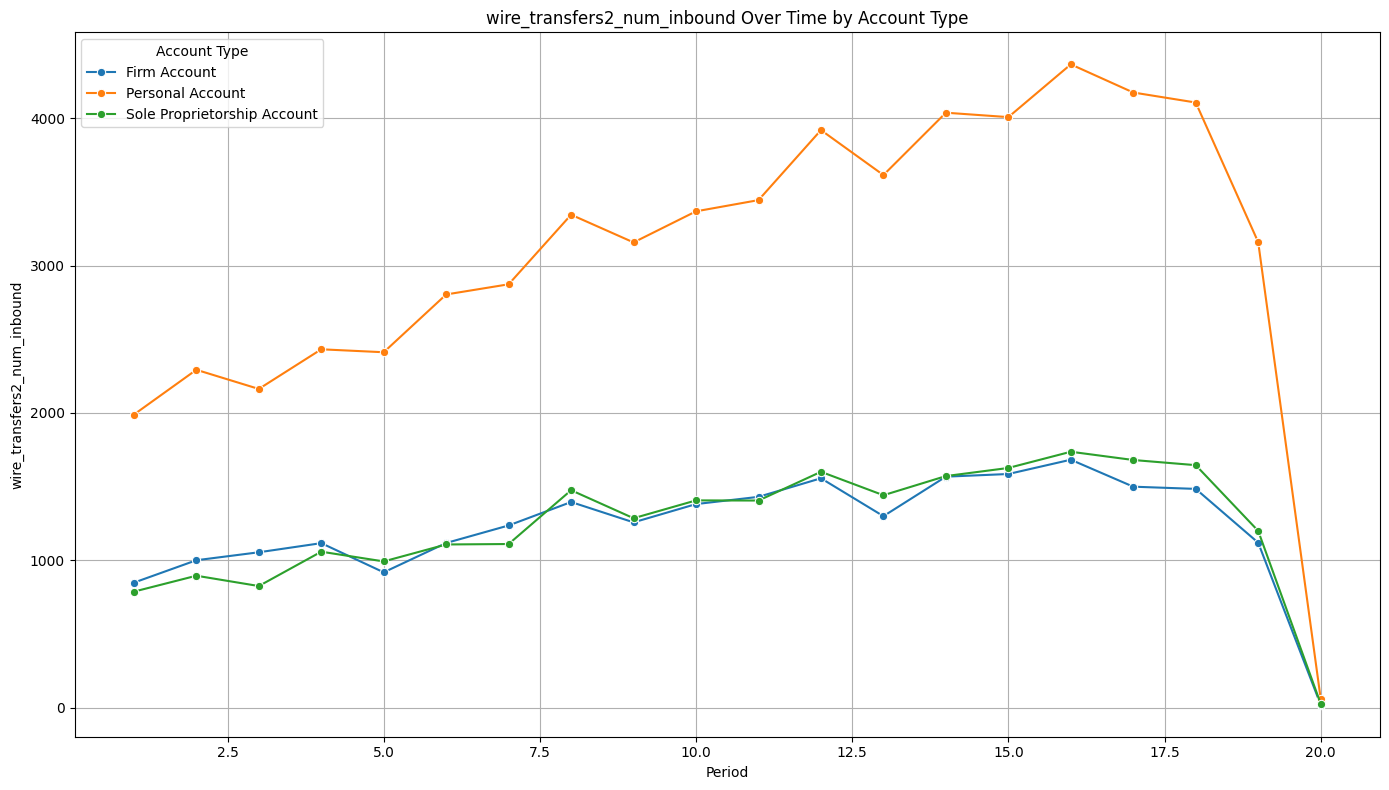

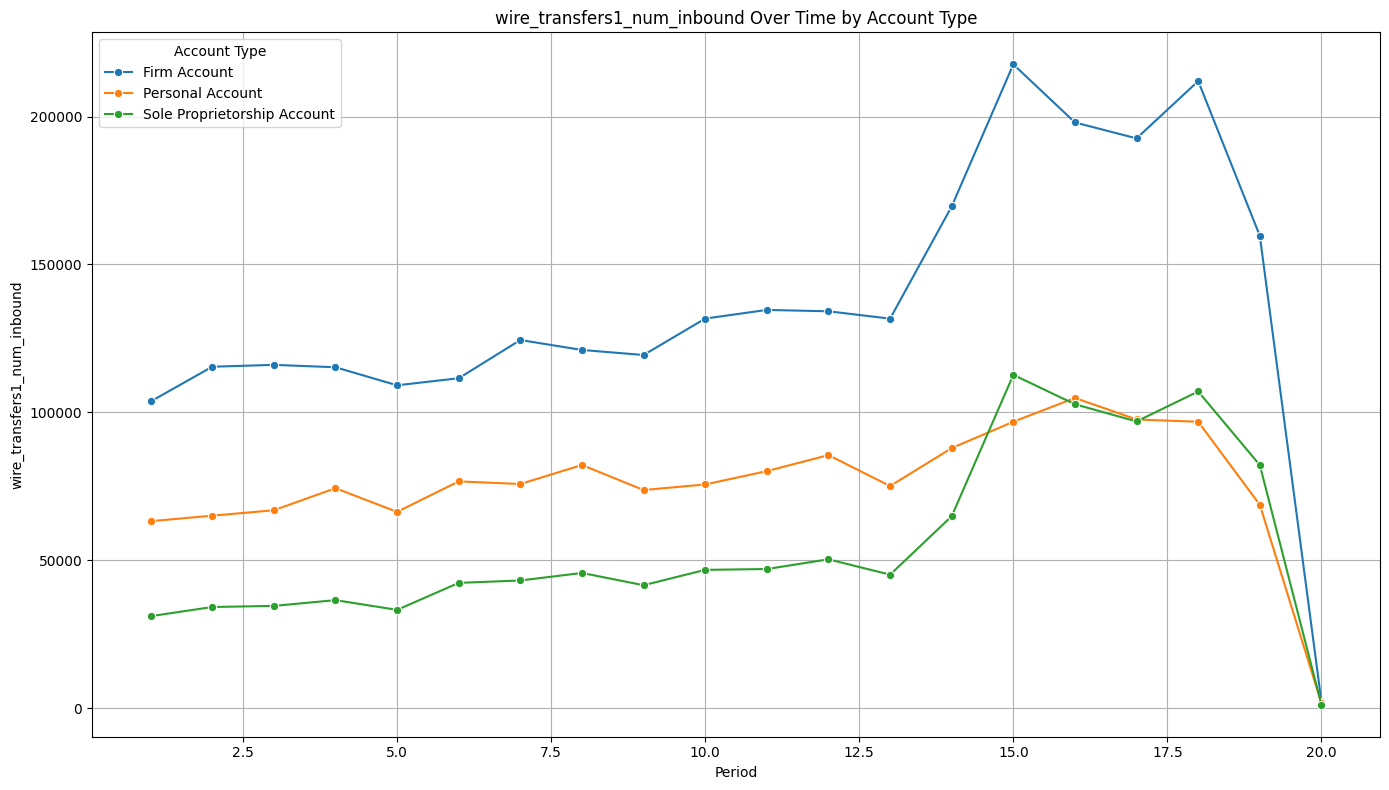

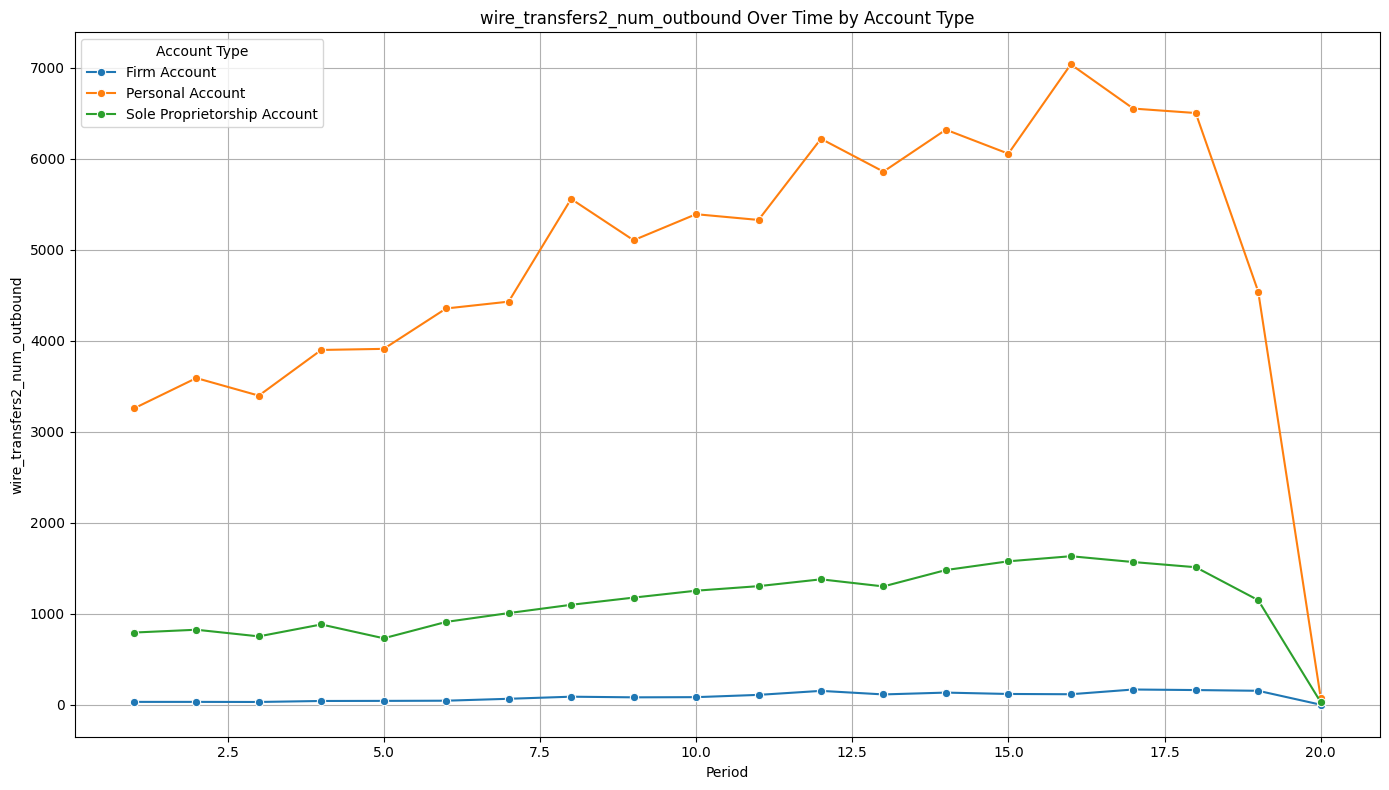

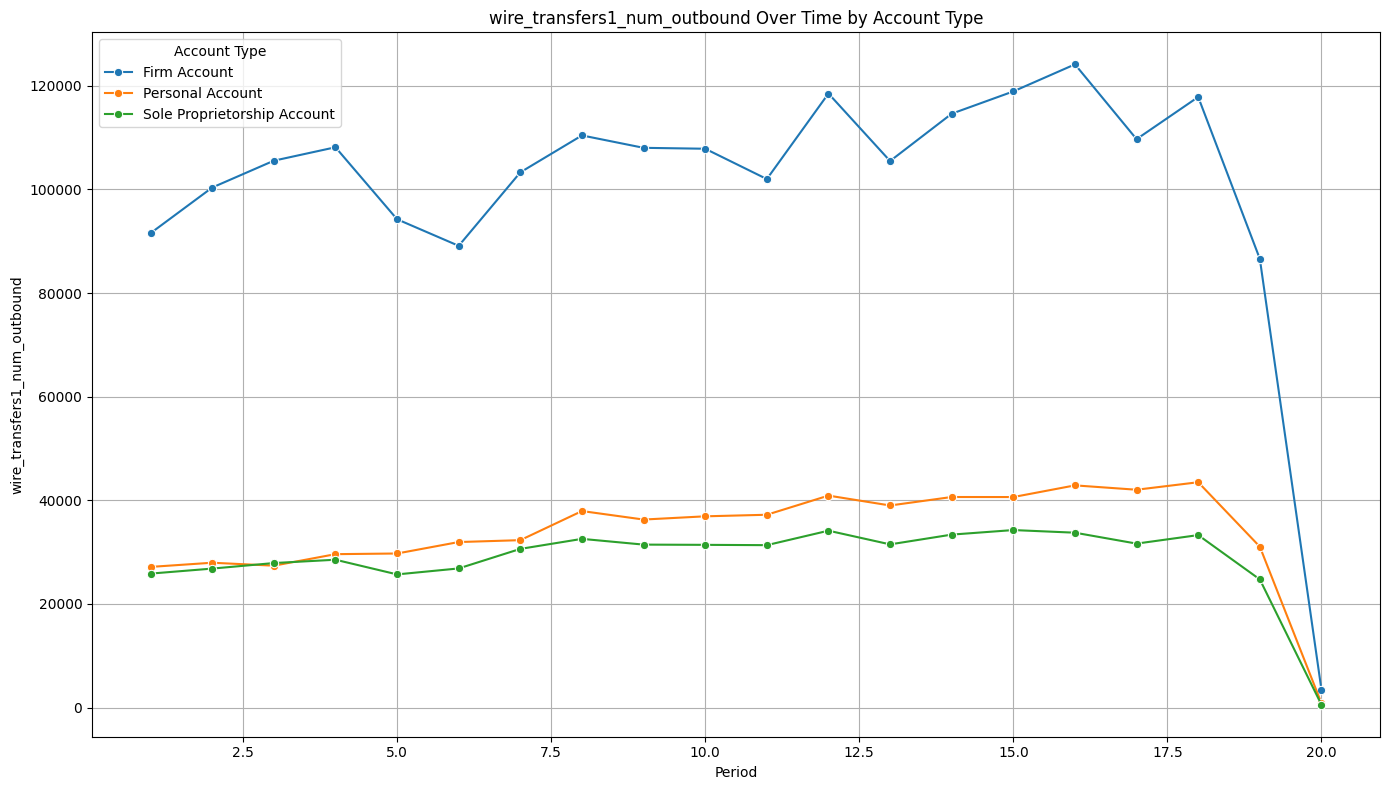

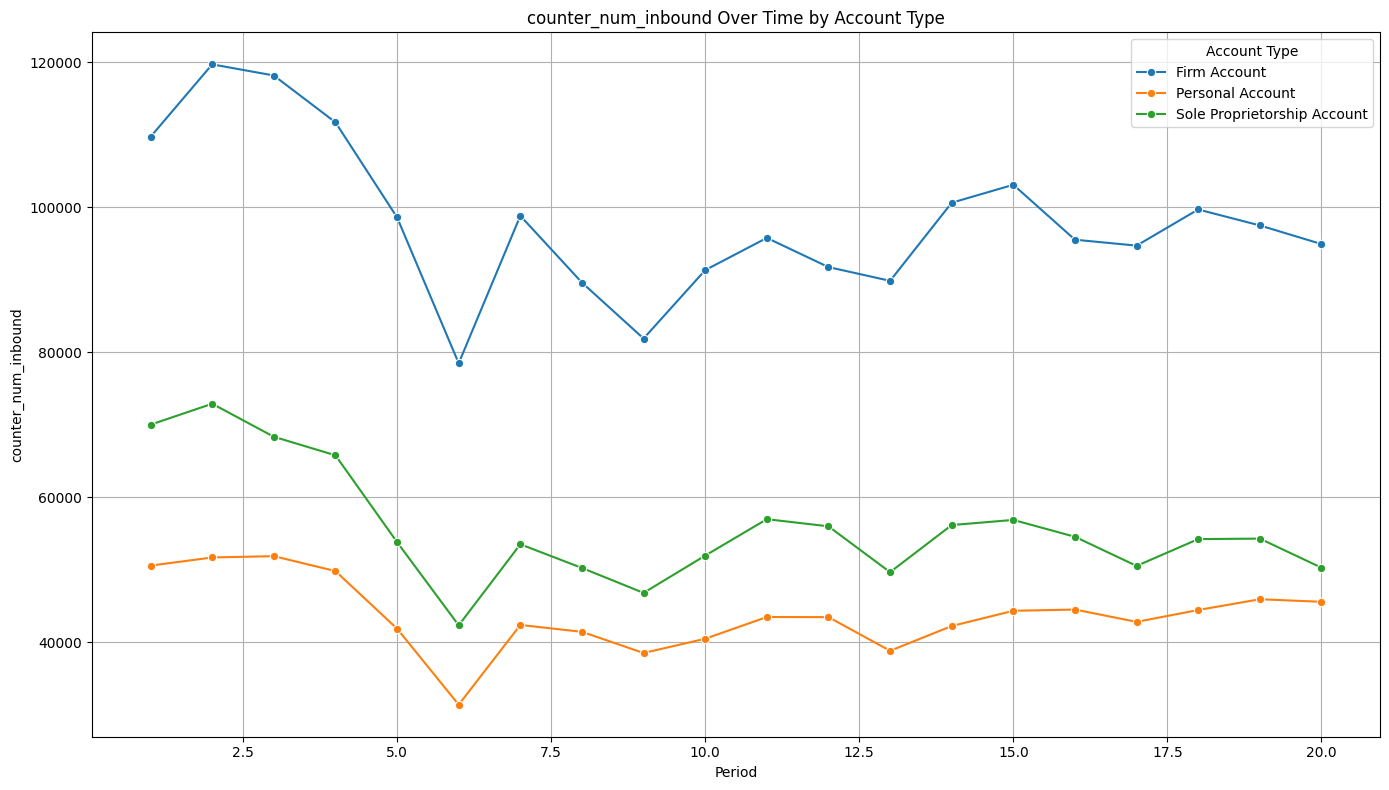

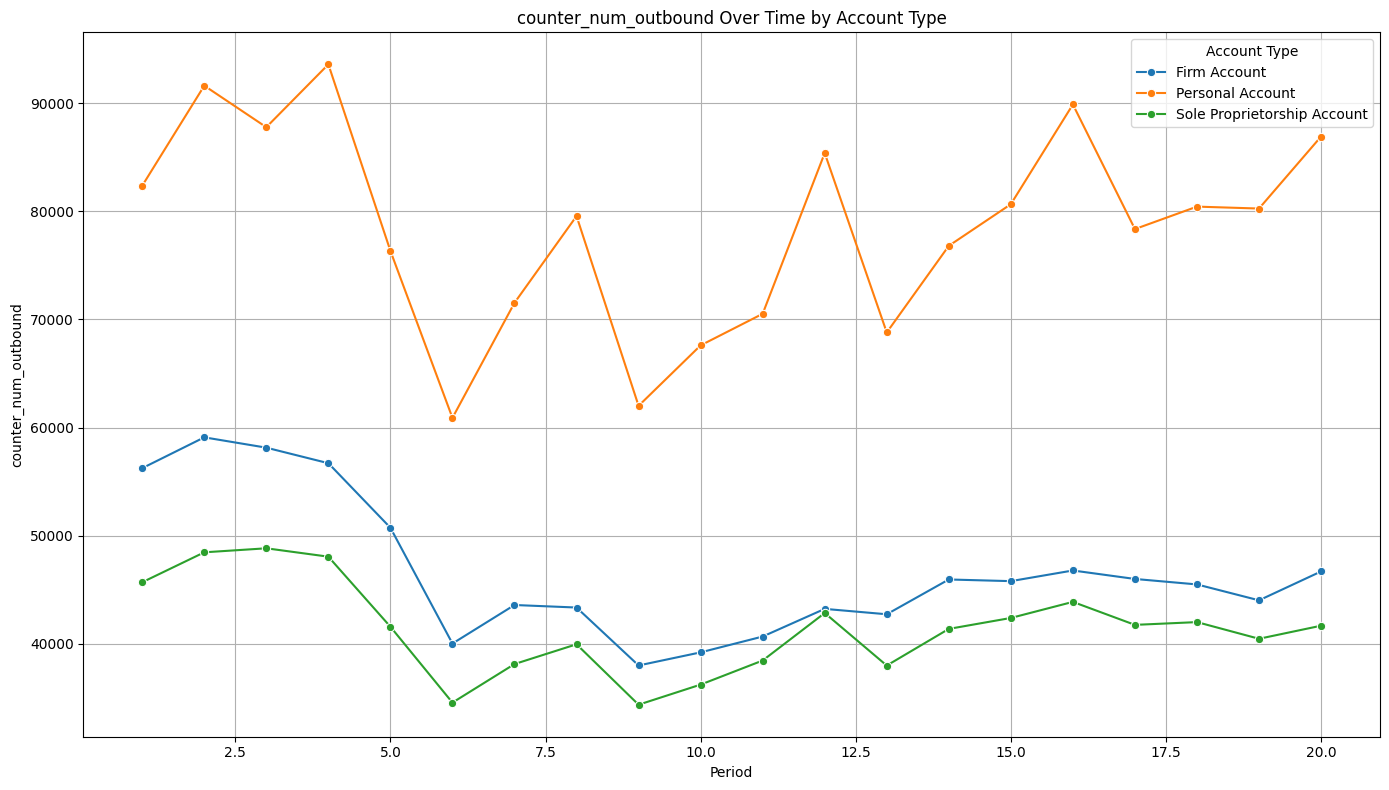

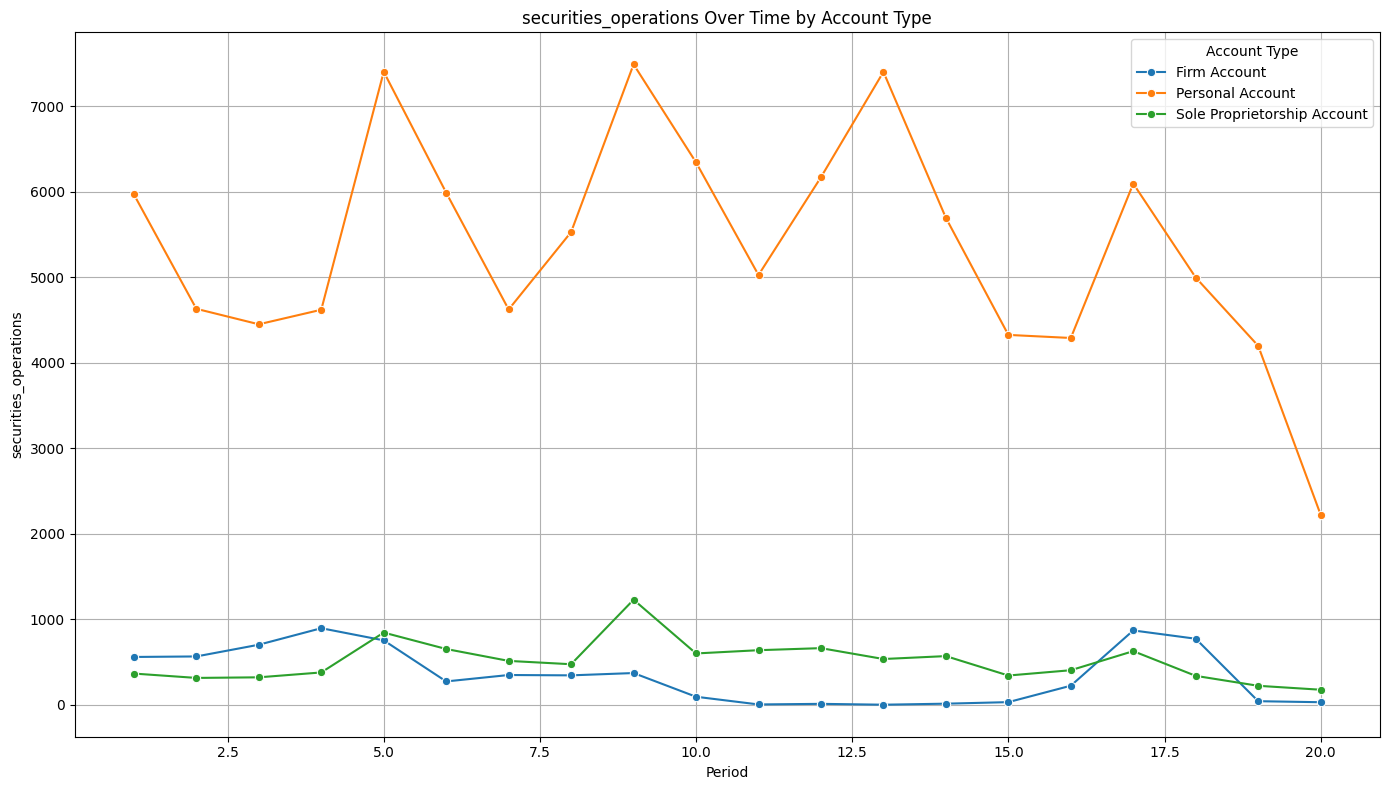

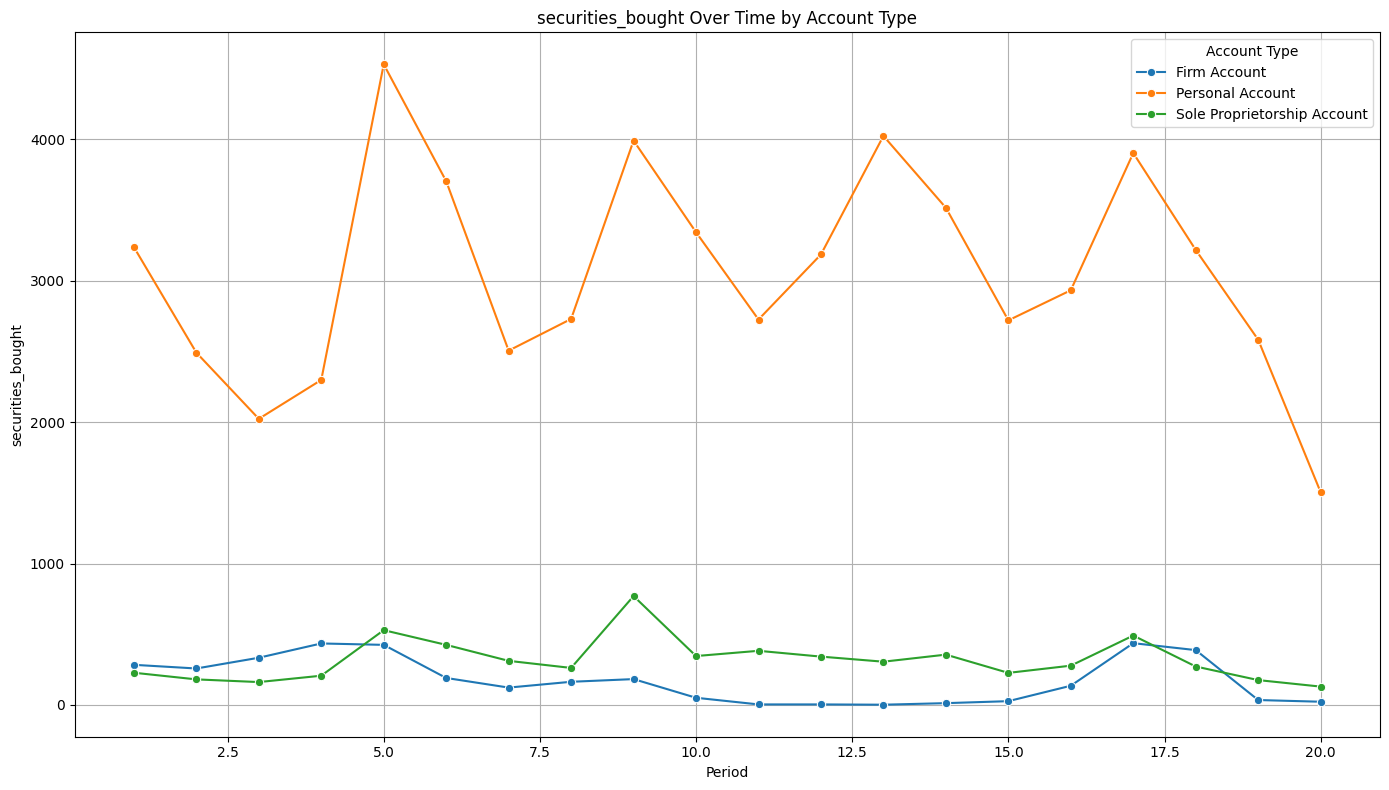

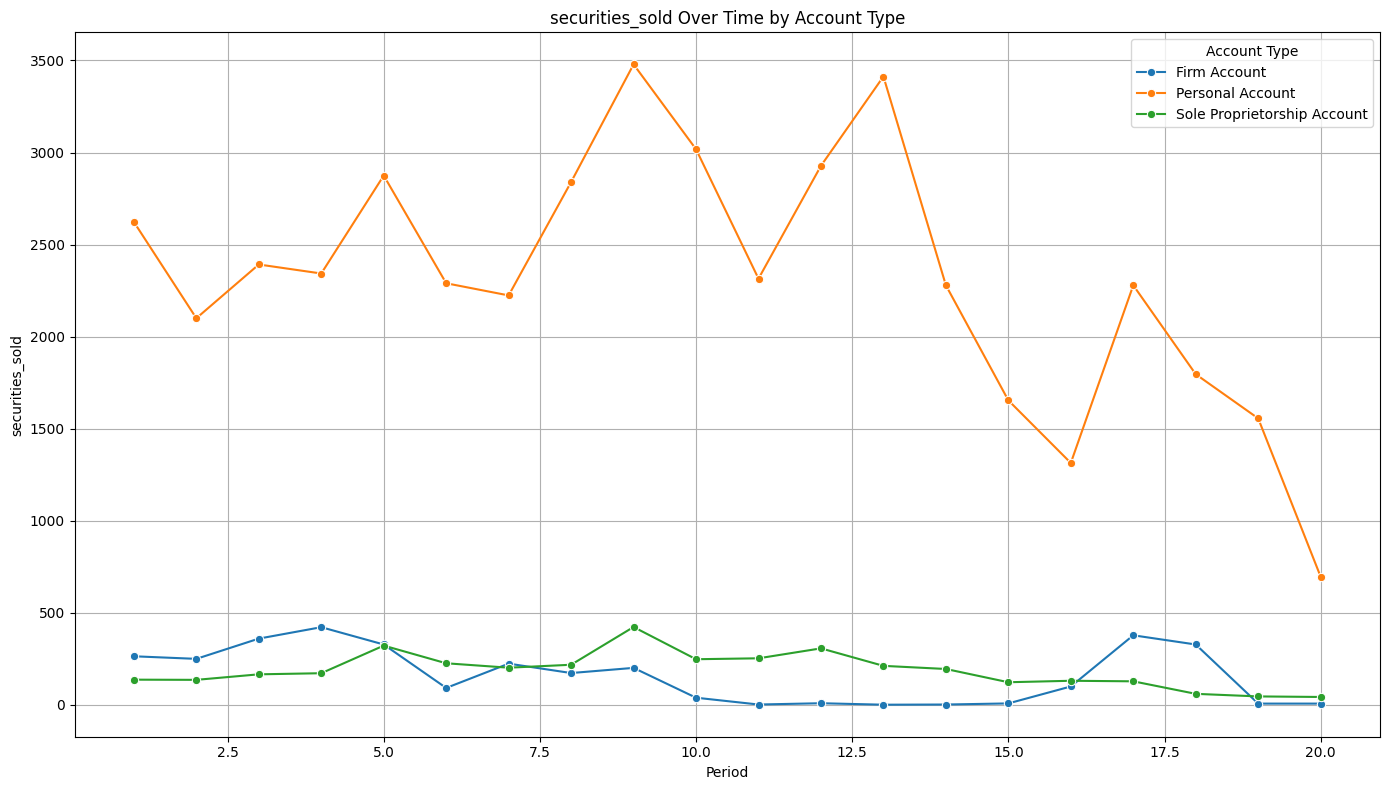

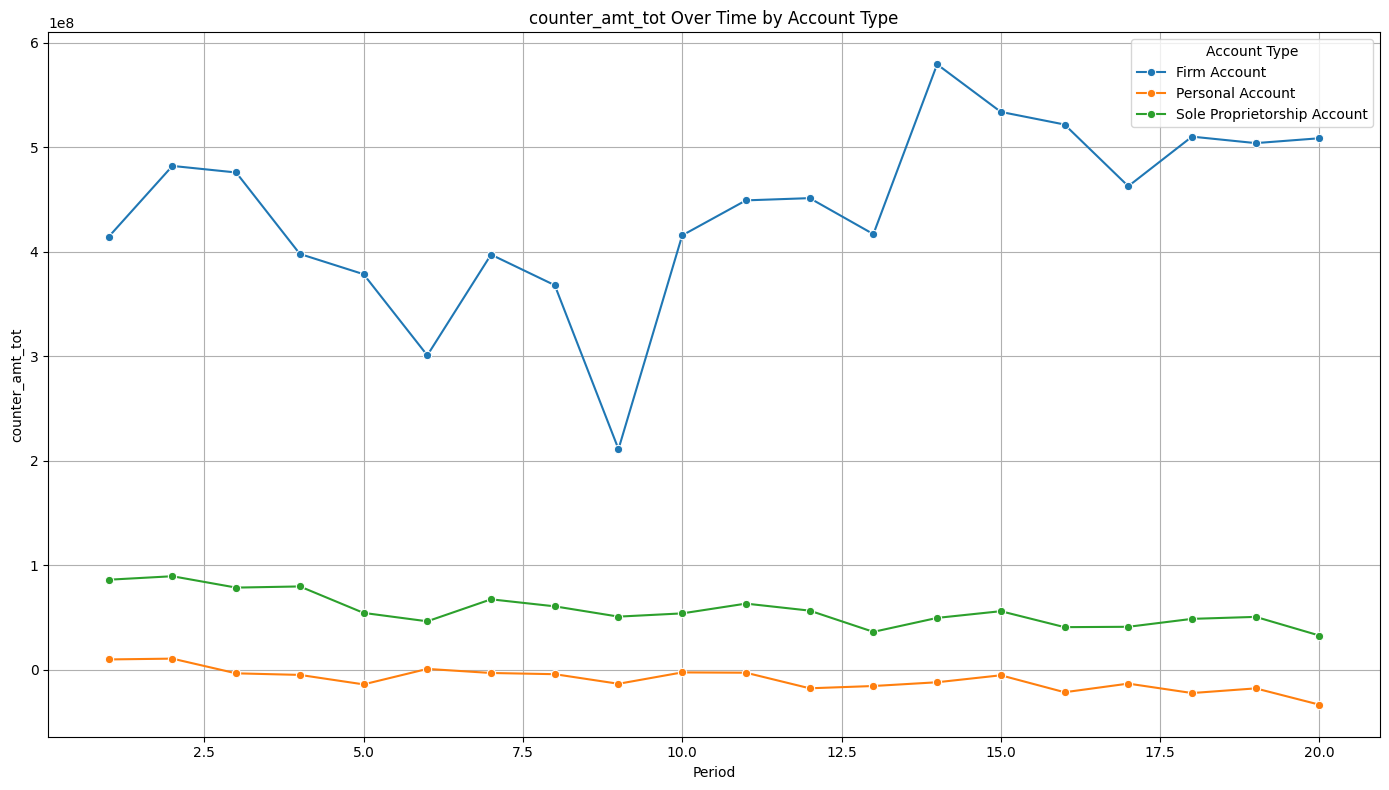

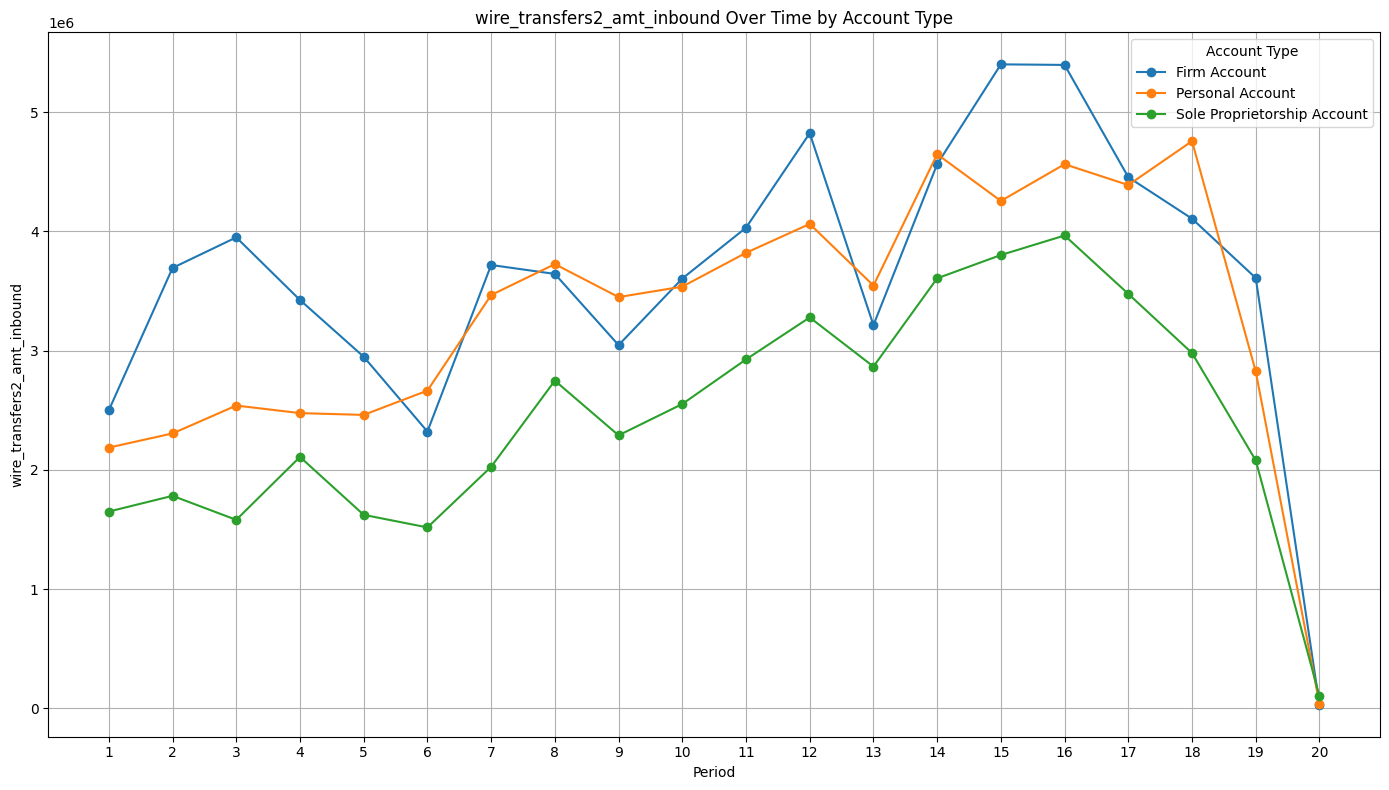

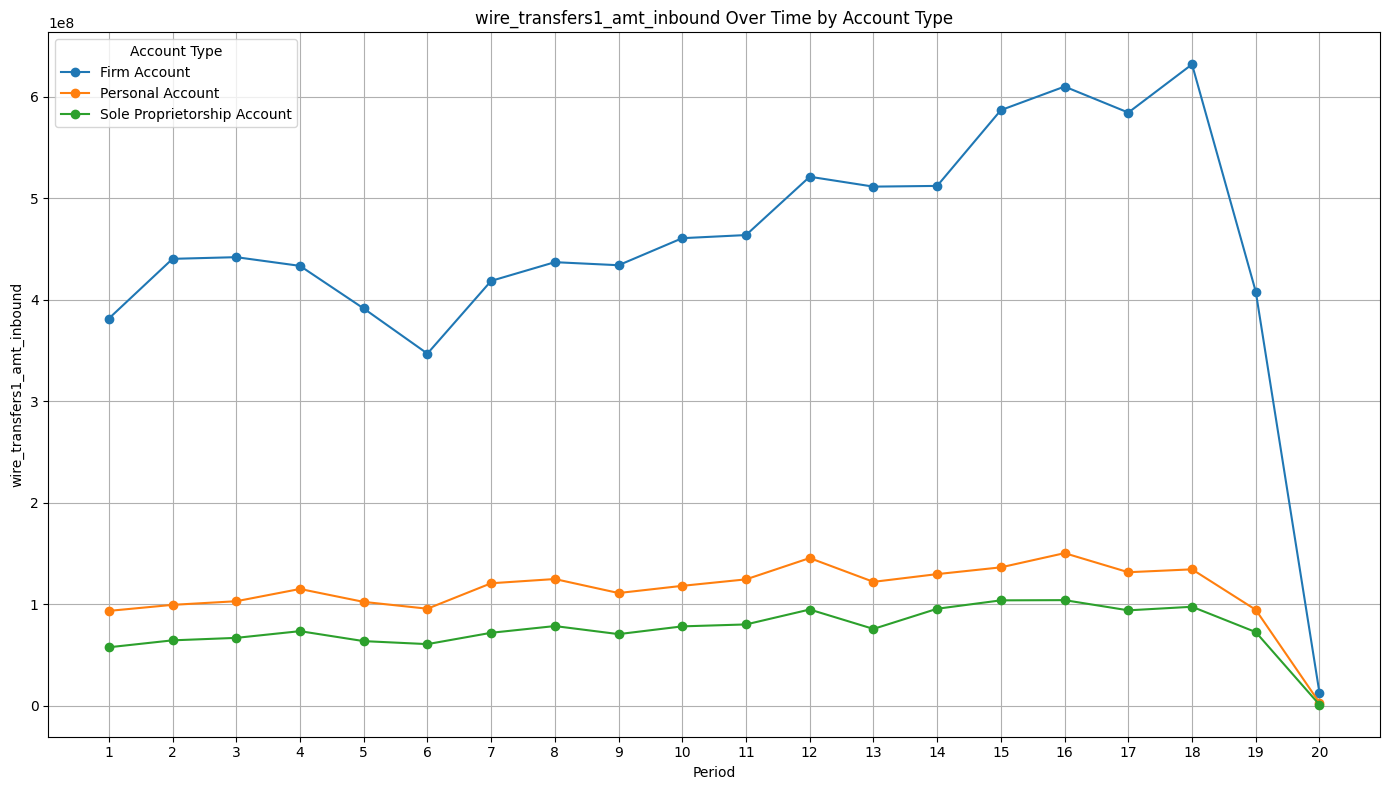

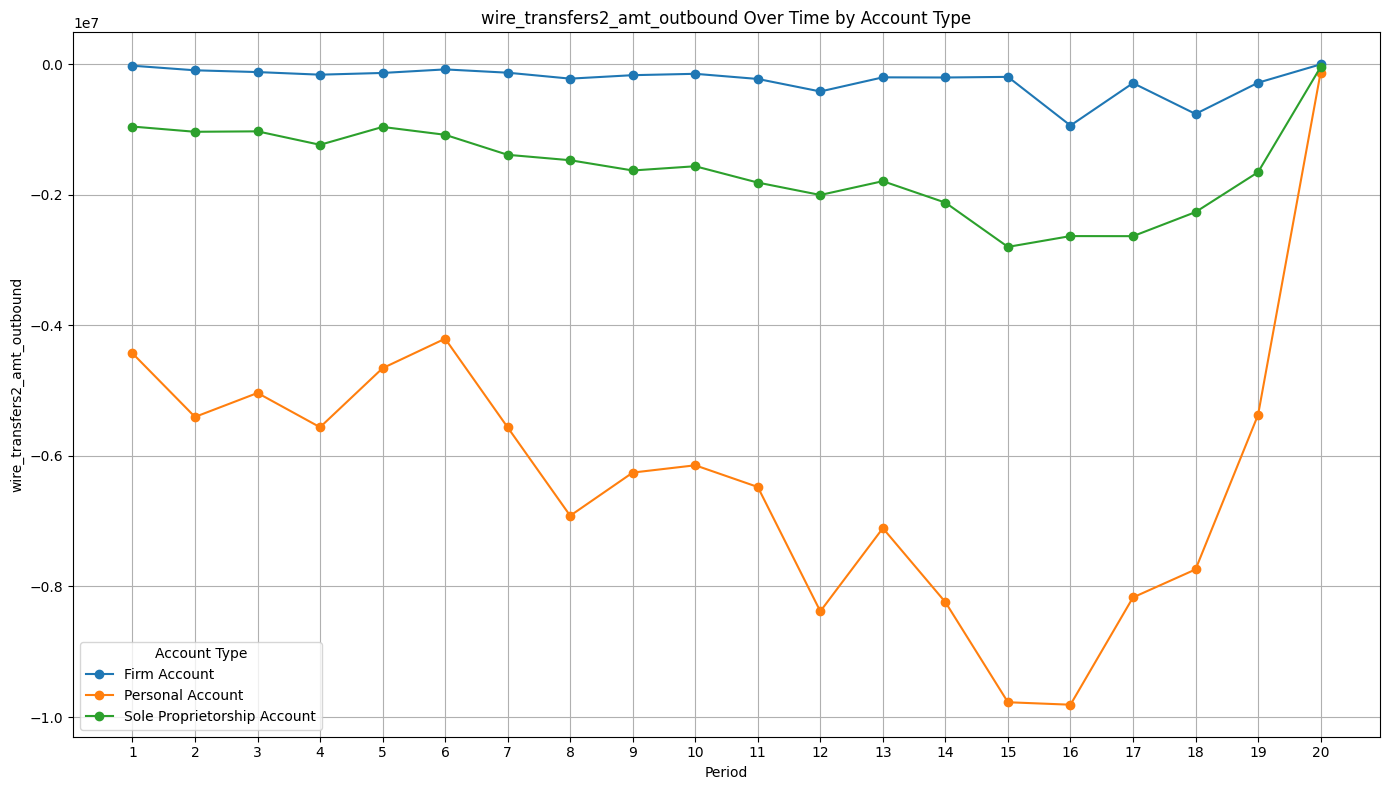

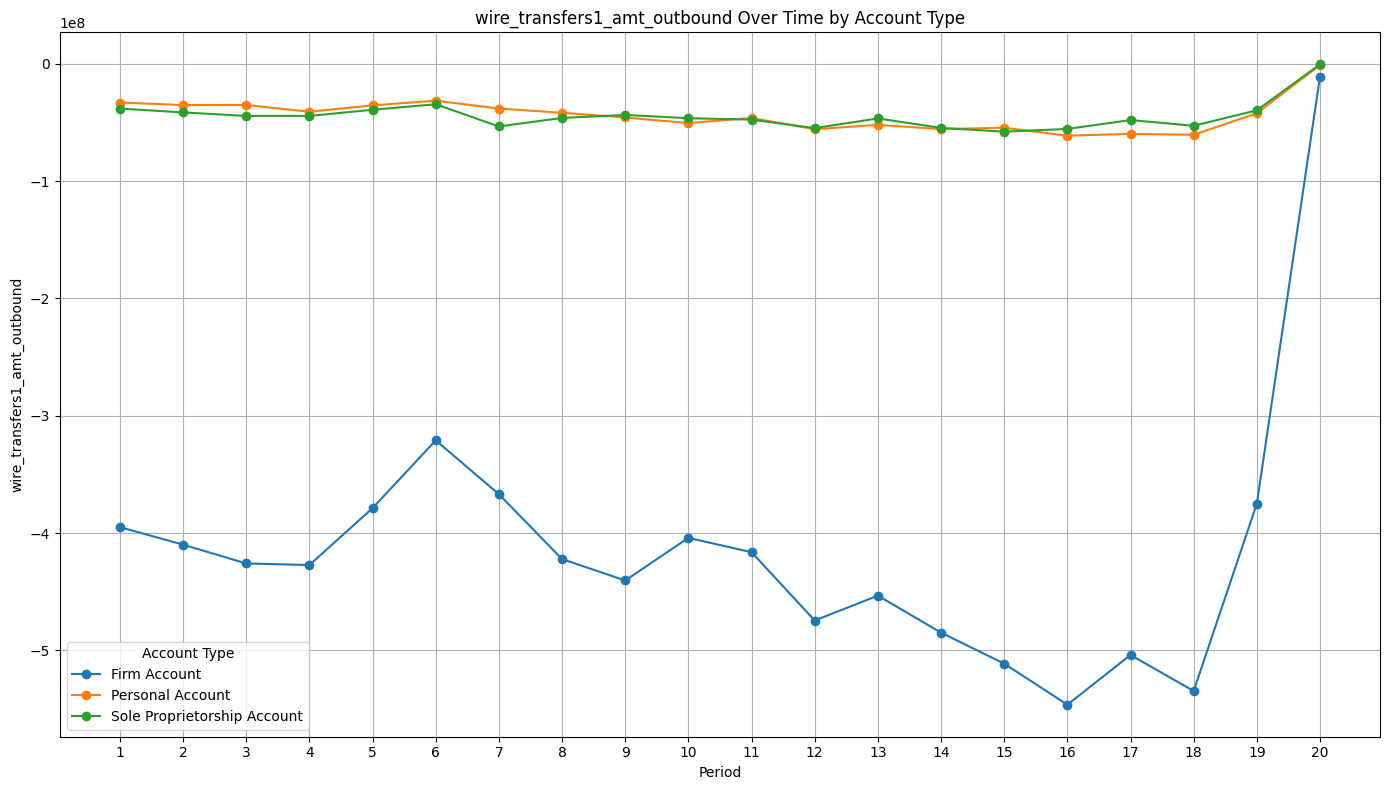

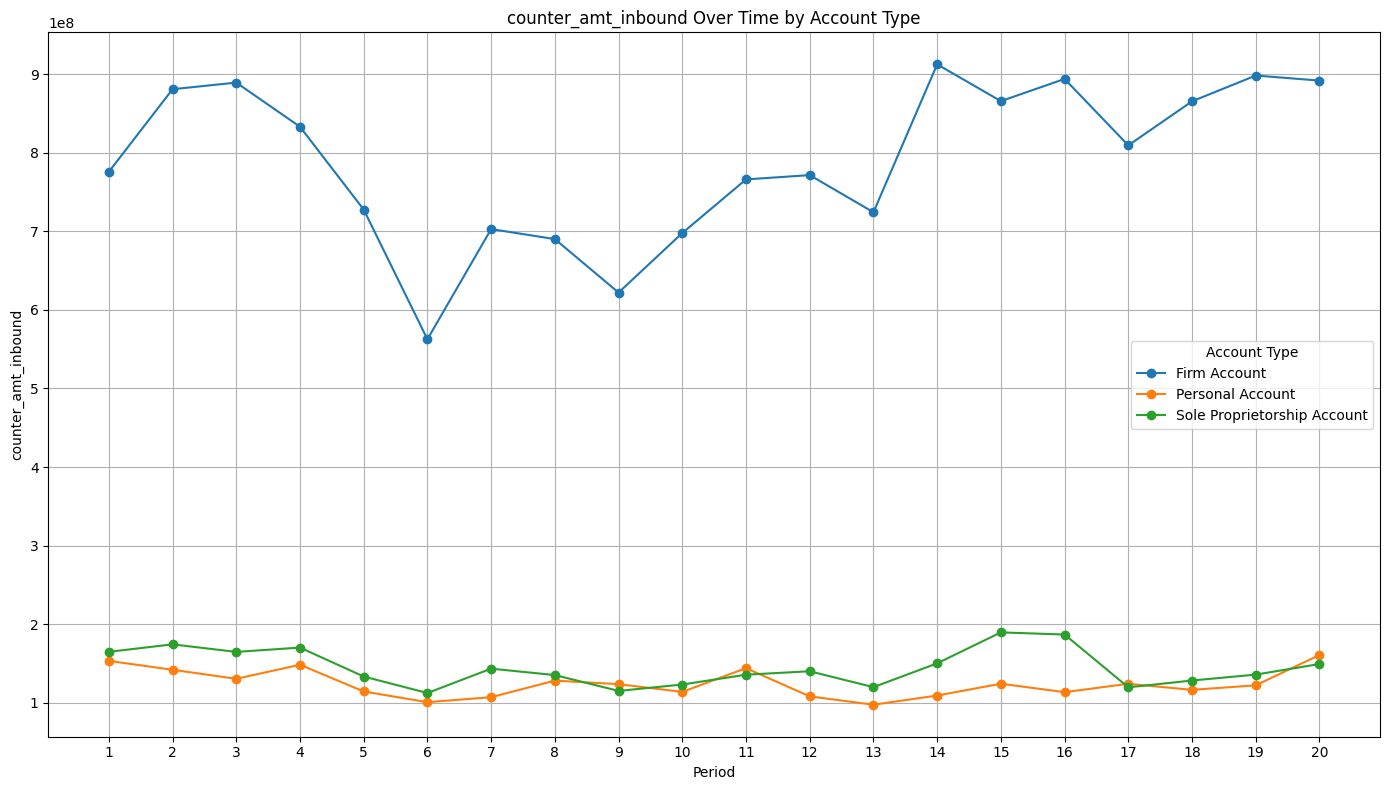

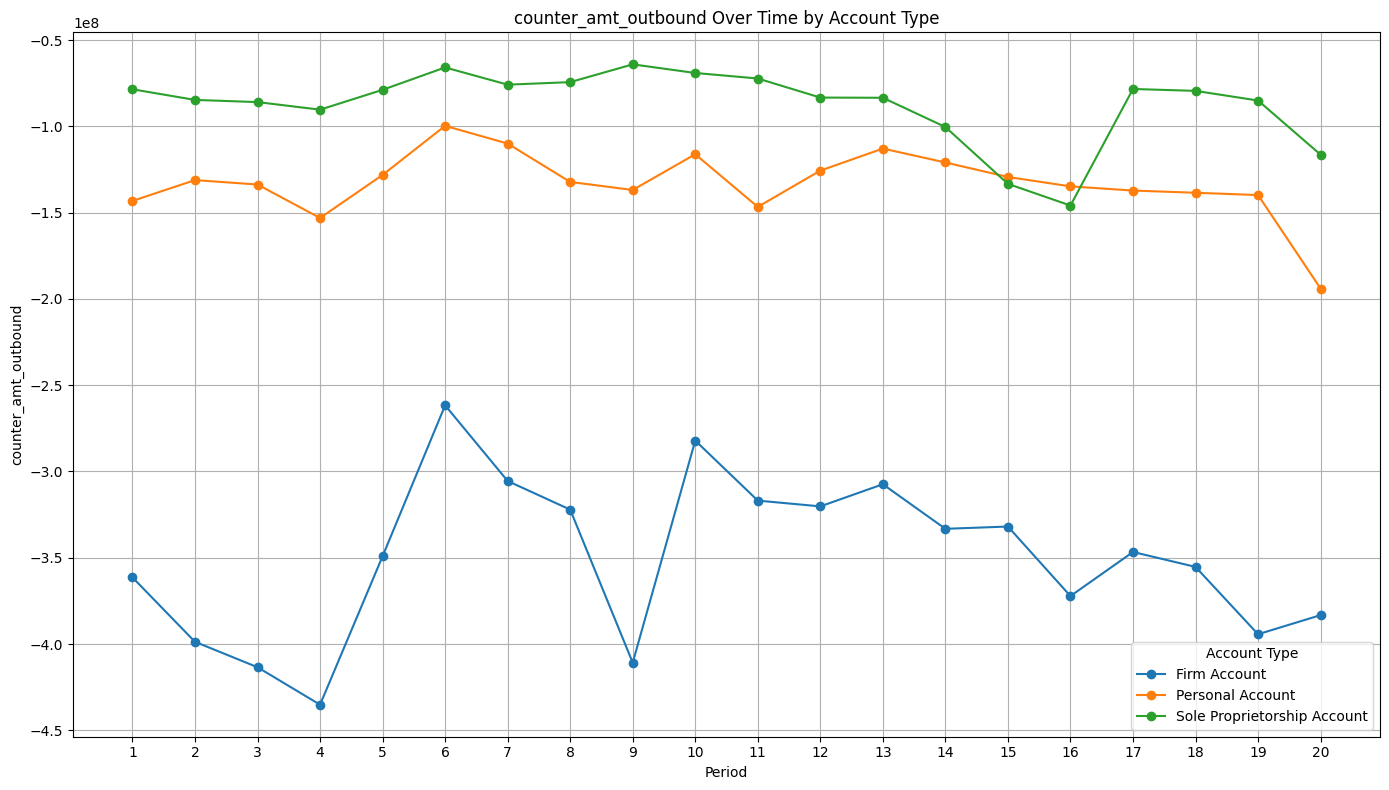

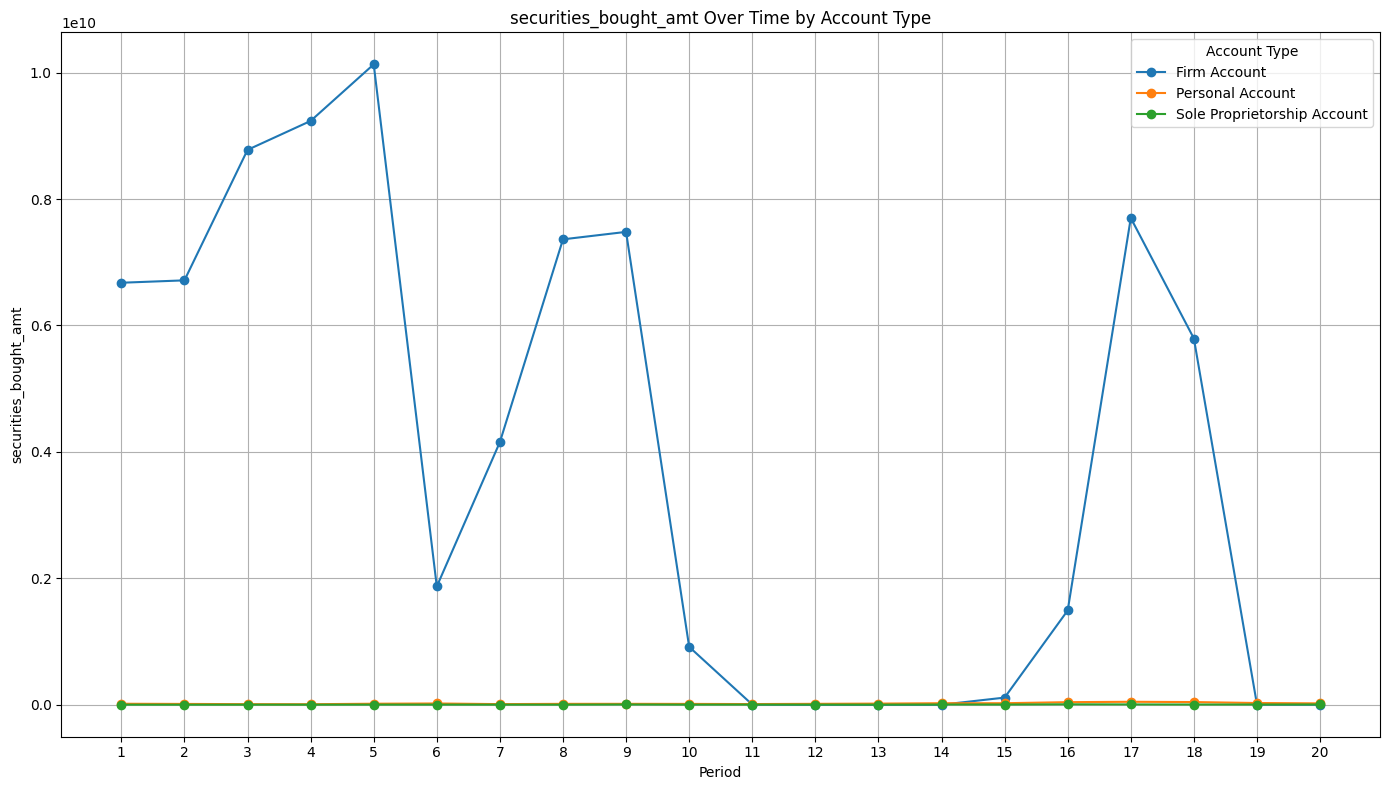

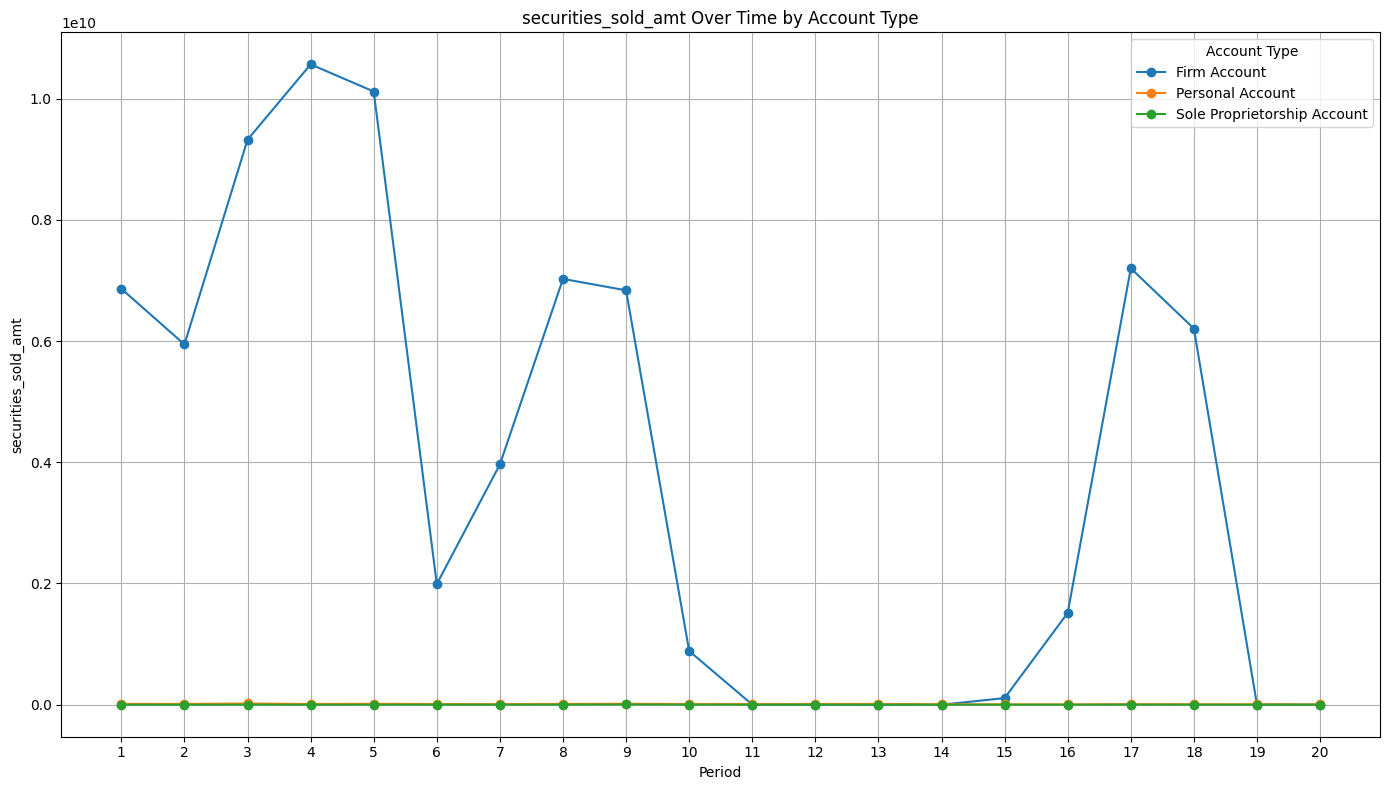

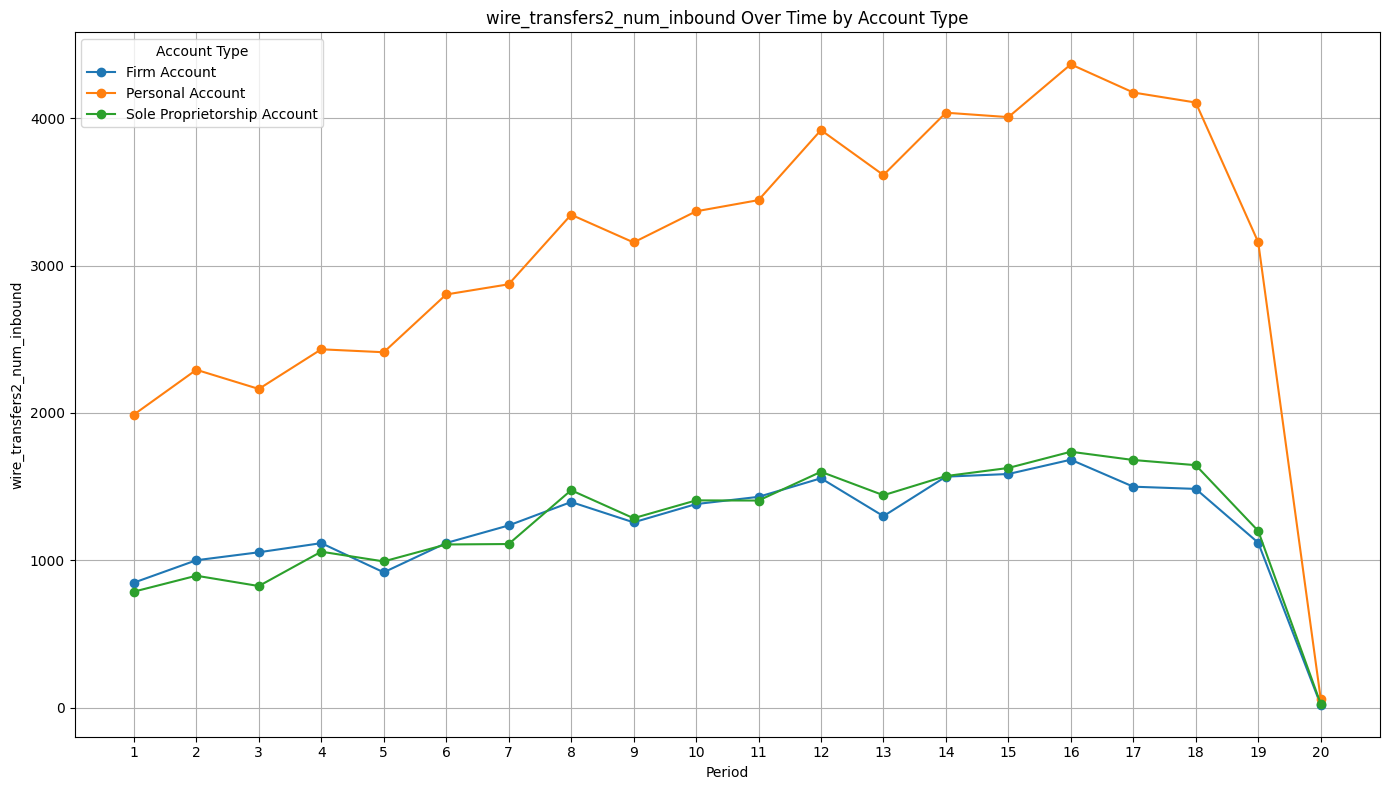

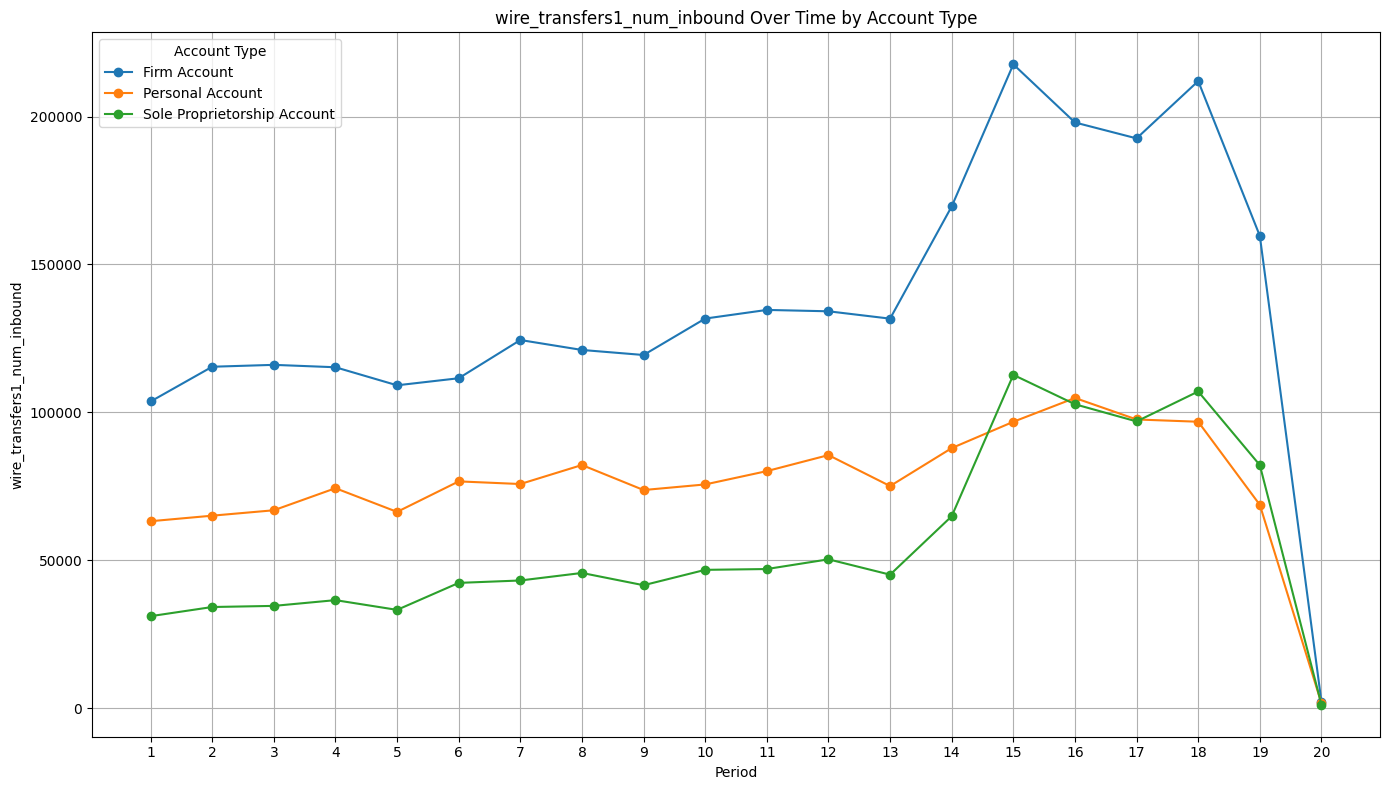

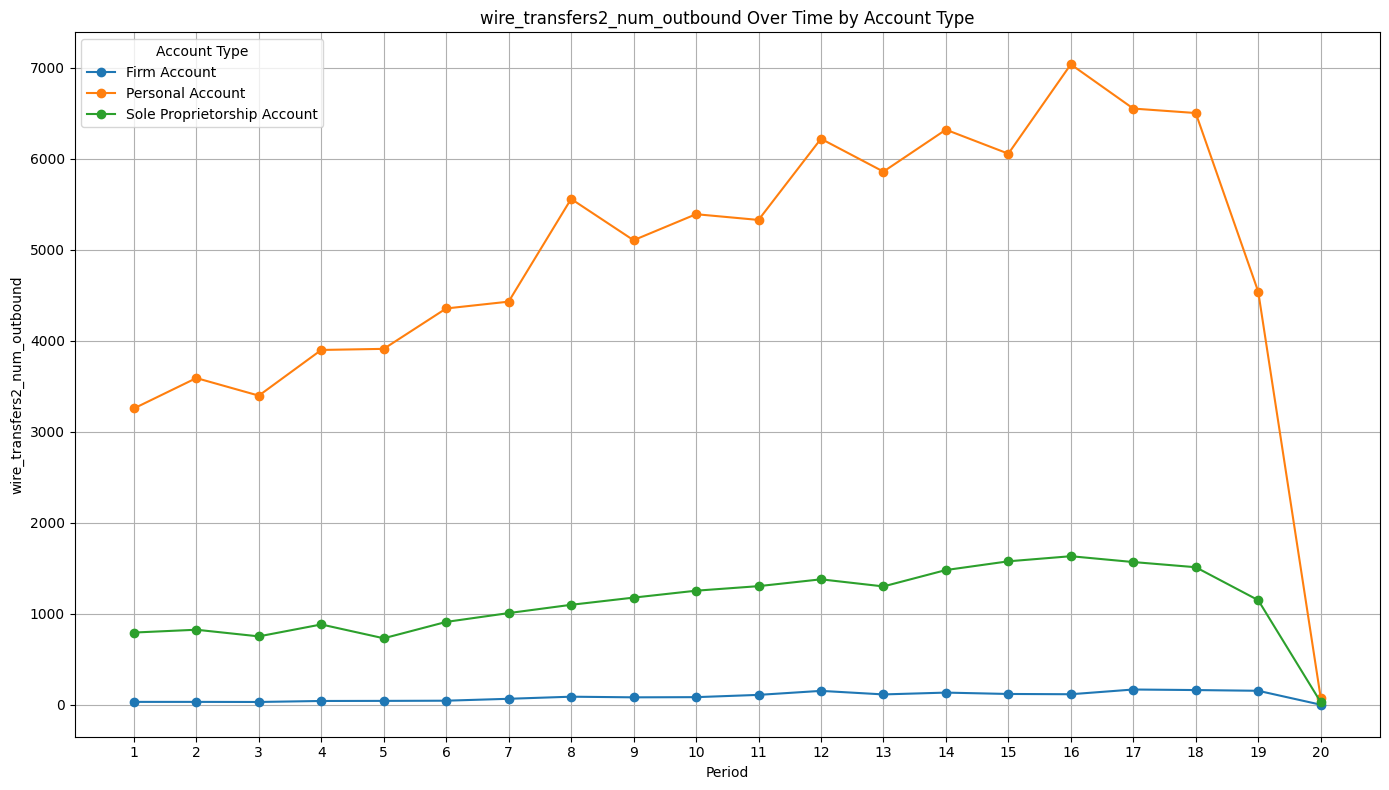

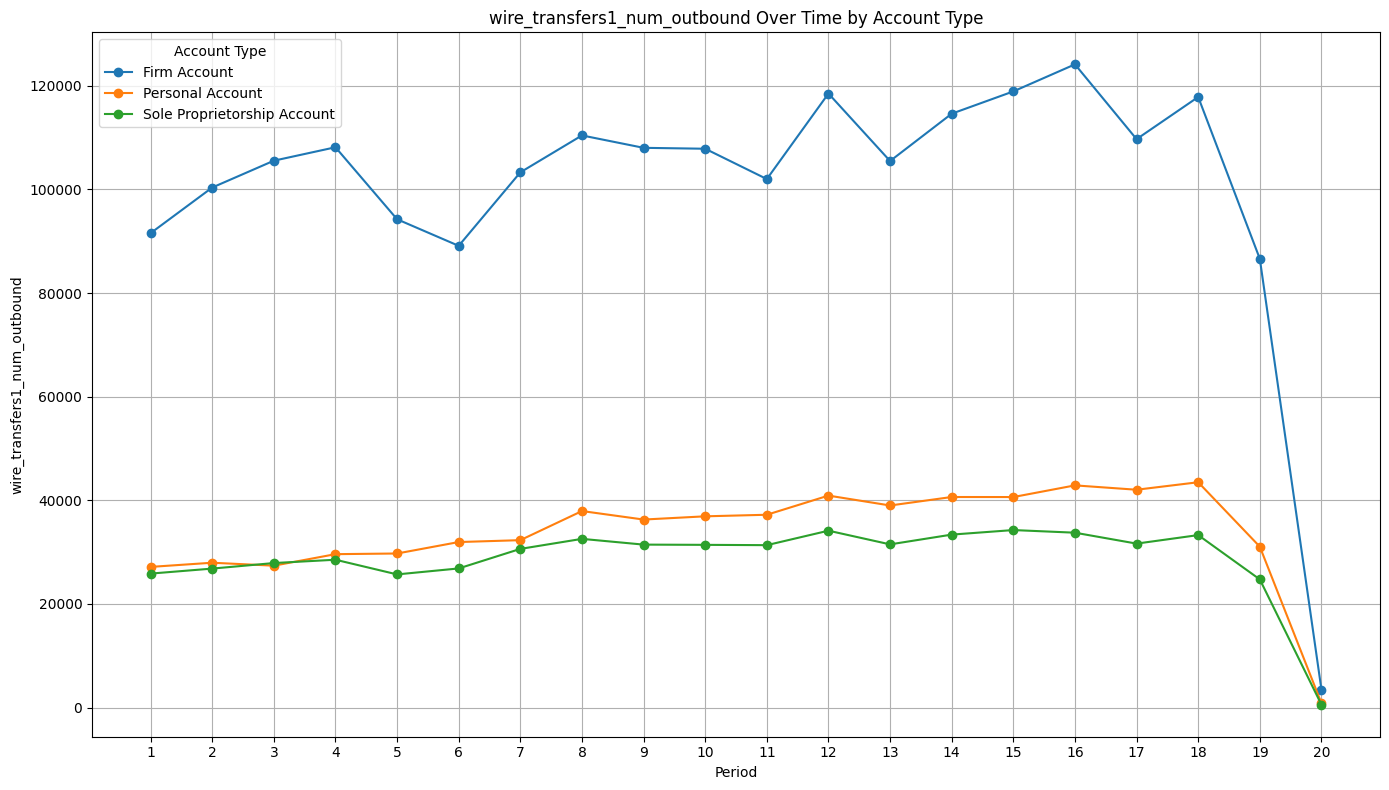

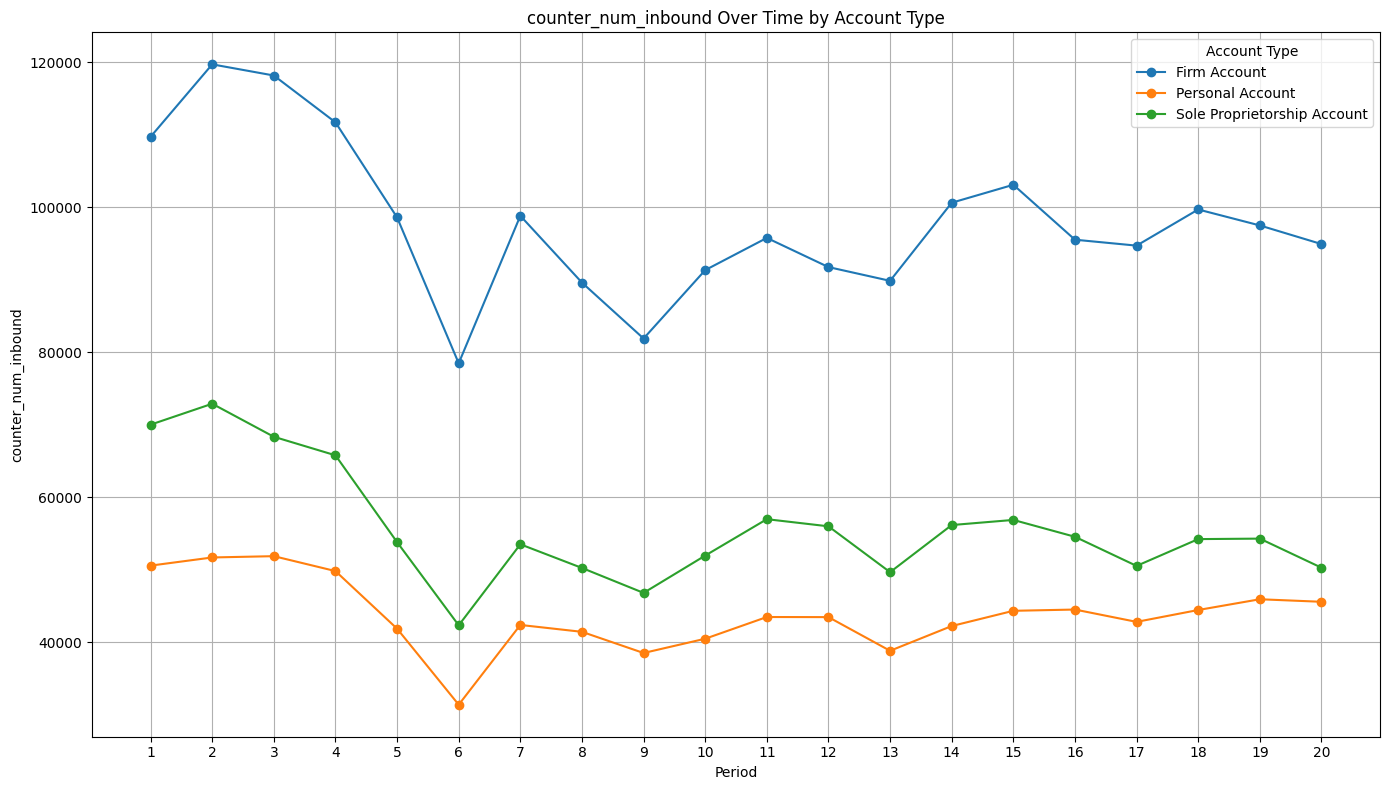

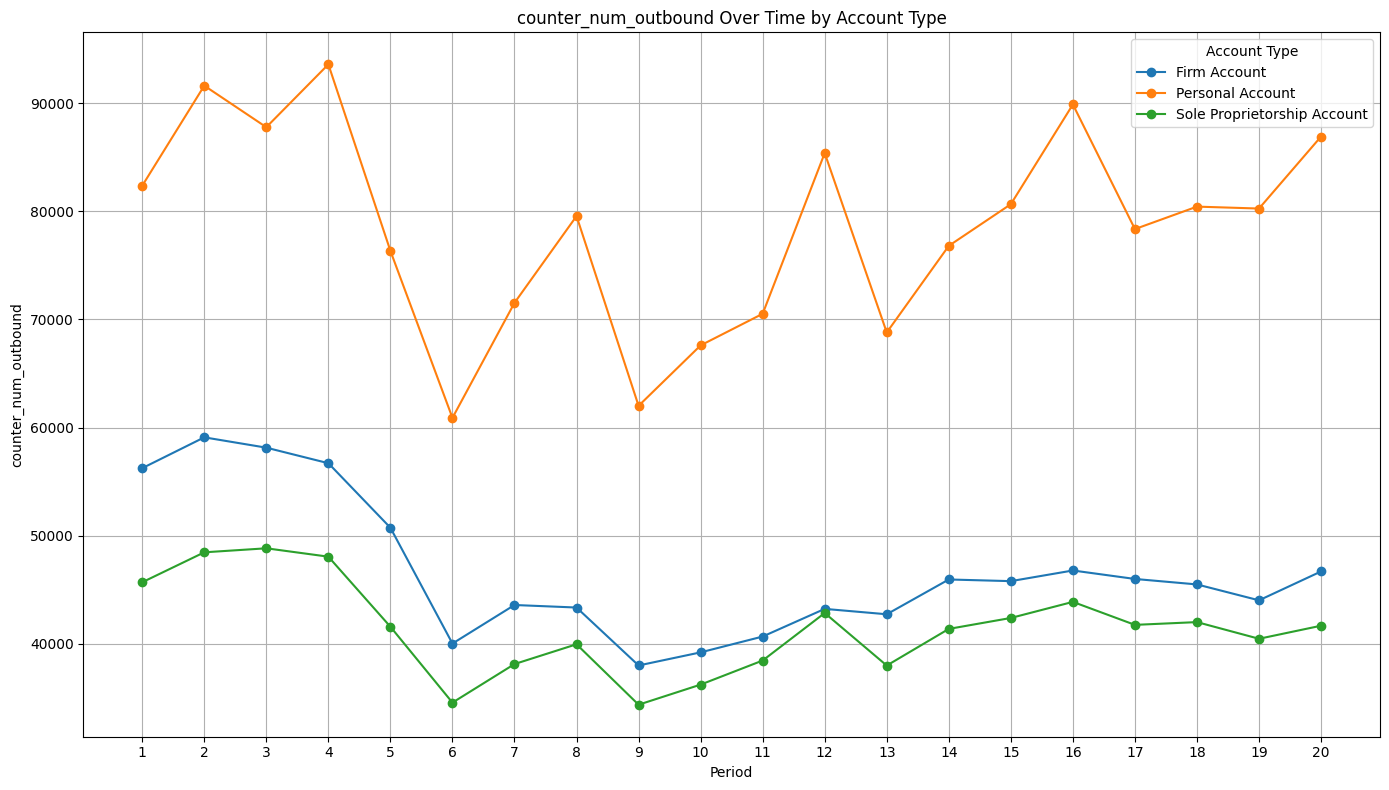

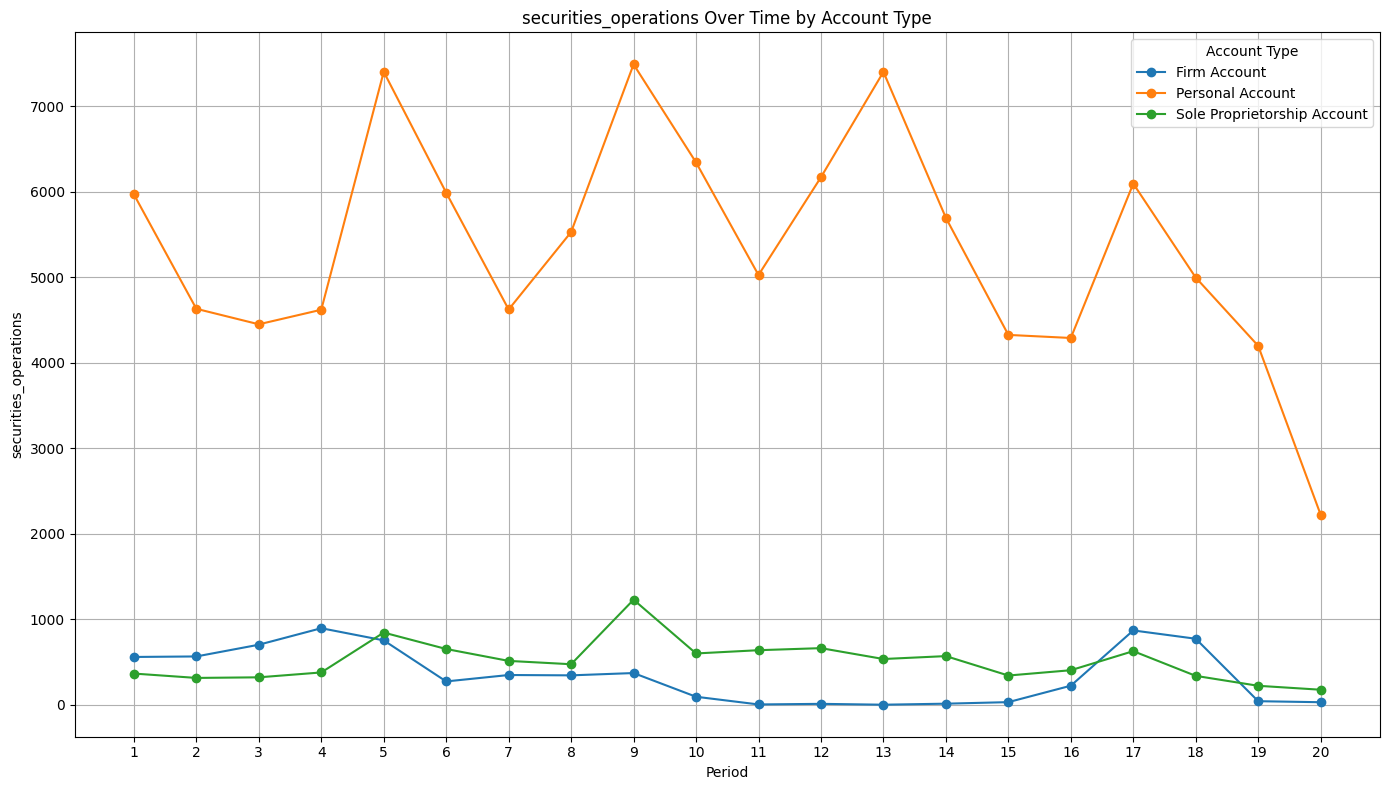

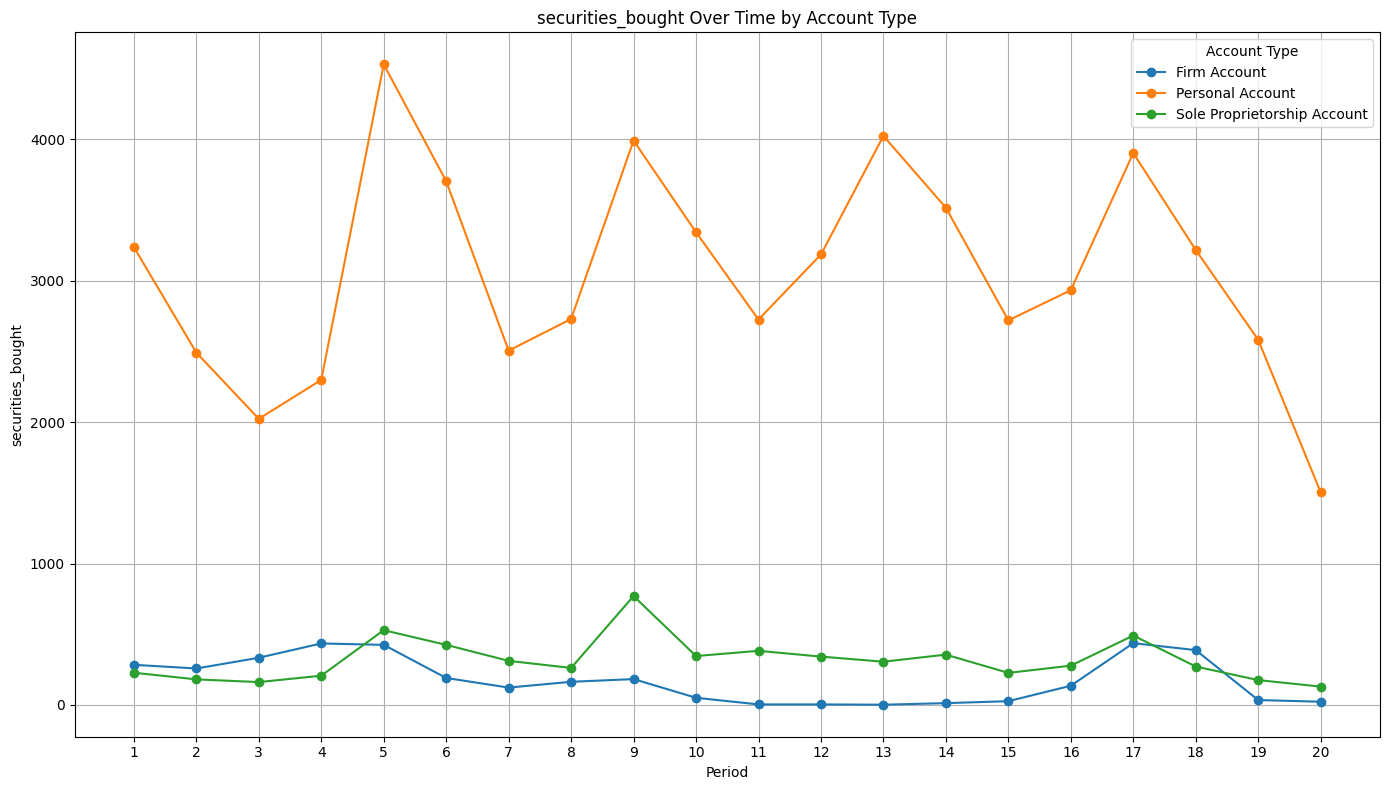

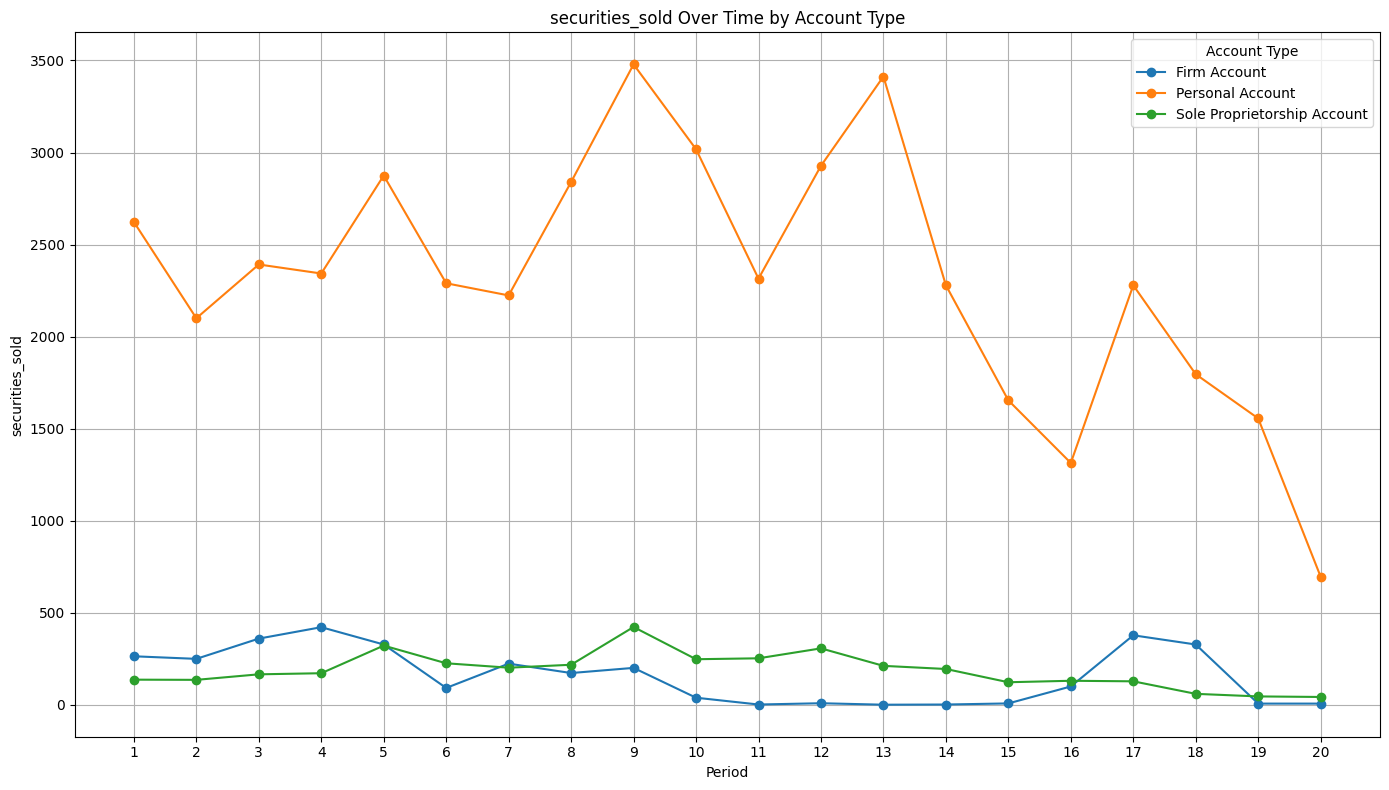

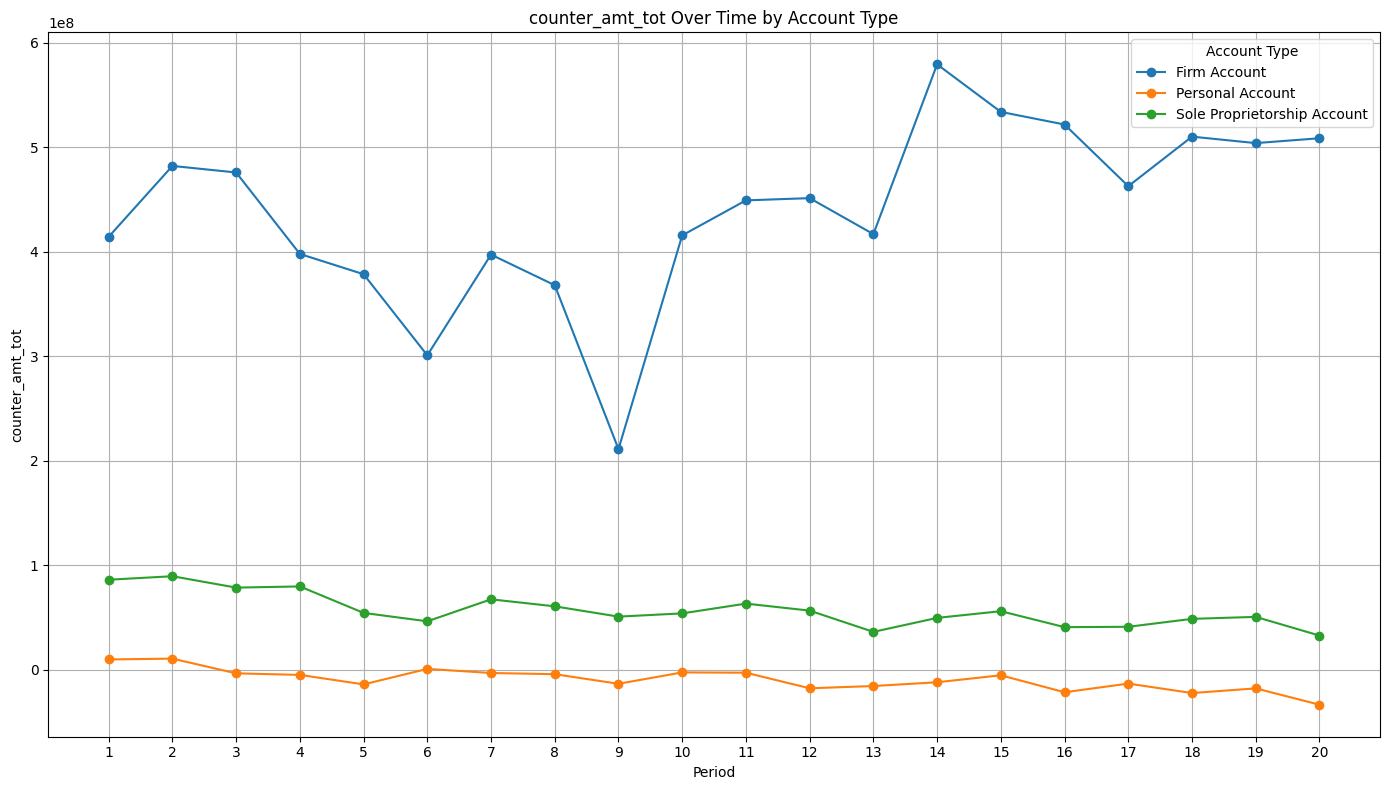

In [36]:
# List of operations to  analyze
operations = [
    'wire_transfers2_amt_inbound', 'wire_transfers1_amt_inbound', 'wire_transfers2_amt_outbound',
    'wire_transfers1_amt_outbound', 'counter_amt_inbound', 'counter_amt_outbound',
    'securities_bought_amt', 'securities_sold_amt', 'wire_transfers2_num_inbound',
    'wire_transfers1_num_inbound', 'wire_transfers2_num_outbound', 'wire_transfers1_num_outbound',
    'counter_num_inbound', 'counter_num_outbound', 'securities_operations', 'securities_bought',
    'securities_sold', 'counter_amt_tot'
]

# Aggregate data for each operation by period and category
agg_df = trial.groupby(['period', 'category_label'])[operations].sum().reset_index()

def plot_operation(operation):
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=agg_df, x='period', y=operation, hue='category_label', marker='o')
    plt.title(f'{operation} Over Time by Account Type')
    plt.xlabel('Period')
    plt.ylabel(f'{operation}')
    plt.legend(title='Account Type')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for each operation
for operation in operations:
    plot_operation(operation)

    # Define a function to plot each operation
def plot_operation(operation):
    plt.figure(figsize=(14, 8))
    
    for label in agg_df['category_label'].unique():
        subset = agg_df[agg_df['category_label'] == label]
        plt.plot(subset['period'], subset[operation], marker='o', label=label)
    
    plt.title(f'{operation} Over Time by Account Type')
    plt.xlabel('Period')
    plt.ylabel(f'{operation}')
    plt.legend(title='Account Type')
    plt.grid(True)
    plt.xticks(subset['period'].unique())  # Ensure all periods are shown
    plt.tight_layout()
    plt.show()

# Plot for each operation
for operation in operations:
    plot_operation(operation)


In [45]:
# Calculate the correlation matrix for the training dataset
corr_client = training_df.corr()

# Create a mask to display only the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr_client, dtype=bool))

# Set up the matplotlib figure size
plt.figure(figsize=(55, 30))

# Generate a heatmap using seaborn to visualize the correlation matrix
sns.heatmap(corr_client, annot=True, cmap='crest', mask=mask)

# Display the heatmap
plt.show()


NameError: name 'training_df' is not defined

# Data Profiling

In [ ]:
def summarize_training_df(training_df):
    recap = []  # Initialize an empty list to store summary information for each column

    # Loop through each column in the DataFrame
    for col in training_df.columns:
        col_type = training_df[col].dtypes  # Get the data type of the column
        unique_vals = training_df[col].nunique()  # Count the number of unique values in the column
        missing_vals = training_df[col].isna().sum()  # Count the number of missing values in the column
        
        # Append the summary for the current column to the recap list
        recap.append([col, col_type, unique_vals, missing_vals])
    
    # Create a summary DataFrame from the recap list
    summary_table = pd.DataFrame(recap, columns=['Column', 'Type', '# Unique', '# Missing'])
    
    return summary_table  # Return the summary DataFrame

# Call the function to generate a summary of the training DataFrame
summarize_training_df(training_df)


In [ ]:
training_df.info()

In [ ]:
training_df.describe().round(0).T

In [ ]:
filtered_cols = ['has_products', 'balance',
       'left_bank', 'joined_bank', 'wire_transfers2_amt_inbound',
       'wire_transfers1_amt_inbound', 'wire_transfers2_amt_outbound',
       'wire_transfers1_amt_outbound', 'counter_amt_inbound',
       'counter_amt_outbound', 'securities_bought_amt', 'securities_sold_amt',
       'wire_transfers2_num_inbound', 'wire_transfers1_num_inbound',
       'wire_transfers2_num_outbound', 'wire_transfers1_num_outbound',
       'counter_num_inbound', 'counter_num_outbound', 'securities_operations',
       'securities_bought', 'securities_sold', 'counter_amt_tot',
       'counter_num_tot']

In [6]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16))
axes = axes.flatten()  

# Plot distribution of each feature in the list
for idx, column in enumerate(filtered_cols):
    if idx < len(axes):
        sns.histplot(training_df[column], kde=True, ax=axes[idx], color='skyblue')
        axes[idx].set_title(f'Distribution of {column}')
        axes[idx].set_xlabel('')
        axes[idx].set_ylabel('')
    else:
        axes[idx].axis('off')  

plt.tight_layout()
plt.show()


# Plot box plots for each feature in the list
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16))
axes = axes.flatten()  

for idx, column in enumerate(filtered_cols):
    if idx < len(axes):
        sns.boxplot(y=training_df[column], ax=axes[idx], color='lightcoral')
        axes[idx].set_title(f'Box Plot of {column}')
        axes[idx].set_xlabel('')
        axes[idx].set_ylabel('')
    else:
        axes[idx].axis('off')  

plt.tight_layout()
plt.show()

# Outliers

In [ ]:
filtered_cols_cols = 3
filtered_cols_plots = len(filtered_cols)
filtered_cols_rows = (filtered_cols_plots // filtered_cols_cols) + (filtered_cols_plots % filtered_cols_cols > 0)

# Box plot for each column
plt.figure(figsize=(15, filtered_cols_rows * 4))
for idx, column in enumerate(filtered_cols):
    plt.subplot(filtered_cols_rows, filtered_cols_cols, idx + 1)
    plt.boxplot(training_df[column], patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title(f'Box Plot of {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [ ]:
## training_df.client_id.nunique() ->  102808
# Group by 'client_id' to analyze the repayment history
grouped = training_df.groupby('client_id')['repays_debt'].apply(list)

history_training_df = grouped.reset_index()
history_training_df.columns = ['client_id', 'Credit_history']

# Clients who always paid back (repays_debt is always 0)
always_paid = history_training_df[history_training_df['Credit_history'].apply(lambda x: all(debt == 0 for debt in x))]

# Clients who went from good to bad
went_from_good_to_bad = history_training_df[history_training_df['Credit_history'].apply(lambda x: 0 in x and 1 in x and x.index(1) > x.index(0))]

# Clients who went from bad to good
went_from_bad_to_good = history_training_df[history_training_df['Credit_history'].apply(lambda x: 1 in x and 0 in x and x.index(0) > x.index(1))]

# Clients who all along never paid back
never_paid = history_training_df[history_training_df['Credit_history'].apply(lambda x: all(debt == 1 for debt in x))]


print(f"Number of clients who always paid back: {len(always_paid)}\nNumber of clients who went from good to bad: {len(went_from_good_to_bad)}\nNumber of clients who went from bad to good: {len(went_from_bad_to_good)}\nNumber of clients who never paid back: {len(never_paid)}")


In [ ]:
# Plot the repayment history by credit history

clients_to_plot = {
    'Always Paid': always_paid['client_id'].iloc[0],
    'Good to Bad': went_from_good_to_bad['client_id'].iloc[0],
    'Bad to Good': went_from_bad_to_good['client_id'].iloc[0],
    'Never Paid': never_paid['client_id'].iloc[0]
}

plt.figure(figsize=(14, 10))


colors = ['#2c7bb6', '#d7191c', '#fdae61', '#abd9e9']  

for i, (category, client_id) in enumerate(clients_to_plot.items(), start=1):
    client_data = training_df[training_df['client_id'] == client_id].sort_values('period')
    
    plt.subplot(2, 2, i)
    plt.plot(client_data['period'], client_data['repays_debt'], marker='*', linestyle='-', color=colors[i-1], linewidth=2)
    plt.title(f'Repaymenet history: {category}', fontsize=14, fontweight='bold')
    plt.xlabel('Period', fontsize=12)
    plt.ylabel('Repayment status', fontsize=12)
    plt.ylim(-0.1, 1.1)
    plt.yticks([0, 1], ['Yes', 'No'])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
client_ids_good_to_bad = went_from_good_to_bad['client_id']

# Filter the original training DataFrame to include only those clients
df_good_to_bad = training_df[training_df['client_id'].isin(client_ids_good_to_bad)]

print(f"Number of unique clients who went from good to bad: {df_good_to_bad['client_id'].nunique()}")

df_good_to_bad.head()


The pattern indicates that these customers engage in low-value transactions.

# Logistic regression: 

In [ ]:
numerical_features = [
    'product8', 'product10', 'product13', 'product12',
    'product11', 'product4', 'product17', 'product2', 'product3',
    'product1', 'product7', 'product6', 'product5', 'product14',
    'product15', 'product16', 'product9', 'has_products', 'balance',
    'left_bank', 'joined_bank', 'wire_transfers2_amt_inbound',
    'wire_transfers1_amt_inbound', 'wire_transfers2_amt_outbound',
    'wire_transfers1_amt_outbound', 'counter_amt_inbound',
    'counter_amt_outbound', 'securities_bought_amt', 'securities_sold_amt',
    'wire_transfers2_num_inbound', 'wire_transfers1_num_inbound',
    'wire_transfers2_num_outbound', 'wire_transfers1_num_outbound',
    'counter_num_inbound', 'counter_num_outbound', 'securities_operations',
    'securities_bought', 'securities_sold', 'counter_amt_tot',
    'counter_num_tot', 'period'
]
categorical_feature = 'category'

# Model building

## Preprocessing

In [ ]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Normalize the features
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())  # One-hot encode
])

# Combine preprocessing steps into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, [categorical_feature])
    ])


## Logistic regression model and parameters

In [ ]:
model = LogisticRegression(solver='saga', penalty='l2', class_weight='balanced', max_iter=1000, verbose = 1)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Specifying the features and target
X = training_df.drop('repays_debt', axis=1)
y = training_df['repays_debt']

# Stratified Split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

## initial results

In [ ]:
# Train the initial model
print("Training the initial model")
pipeline.fit(X_train, y_train)

# Make predictions
print("Making predictions")
y_pred = pipeline.predict(X_test)

# Evaluate the model
initial_recall = recall_score(y_test, y_pred)
initial_f1 = f1_score(y_test, y_pred)
initial_auc_roc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])

print(f"Initial Recall: {initial_recall}")
print(f"Initial F1-Score: {initial_f1}")
print(f"Initial AUC-ROC: {initial_auc_roc}")

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve")

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()